# Import packages/data

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import warnings
warnings.filterwarnings('ignore')
import copy
from scipy import signal
import matplotlib.pylab as pl
import matplotlib.transforms as mtransforms
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates

## Import flux data

In [2]:
# Read in isotope data
docID = '1T7q2lsuj6WuHQWK3pmsaWUvvrpKhIRDEif_1PM_jMPc' # after /d/ in url
gID = '477749500' # after gid= in url
isotopes = pd.read_csv('https://docs.google.com/spreadsheets/d/' + docID + '/export?gid=' + gID + '&format=csv')

isotopes['Time Collected'] = isotopes['Time Collected'].fillna('12:00')
isotopes['timestamp'] = isotopes['Date Collected'] + ' ' + isotopes['Time Collected']
isotopes['timestamp'] = pd.to_datetime(isotopes['timestamp'], errors='raise')
isotopes.index = isotopes['timestamp']
isotopes['timestamp_rounded'] = isotopes.index.round('H').copy()
isotopes = isotopes.drop(isotopes[isotopes.FLAG == 1].index) # remove flagged data
isotopes['waterYear']=np.where(~isotopes.index.month.isin([10,11,12]),
                             isotopes.index.year, isotopes.index.year+1)
VMS_isotopes = isotopes[isotopes['Sample Type II'] == 'VMS'] # create df of VMS isotopes
VMS_isotopes['dD'] = pd.to_numeric(VMS_isotopes['dD'])
precip_isotopes = isotopes[(isotopes['Sample Type II'] == 'Rain')&(isotopes['Site'] != 'Sagehorn')] # create df of Angelo precip isotopes
precip_isotopes['waterYear']=np.where(~precip_isotopes.index.month.isin([10,11,12]),
                             precip_isotopes.index.year, precip_isotopes.index.year+1)
precip_isotopes['dD'] = pd.to_numeric(precip_isotopes['dD'])
df=isotopes
solid_isotopes = df.loc[(df['Site']=='Rivendell') & (df['Sample Type']=='Soil or rock')]# & (df['Location']=='VMS1')|(df['Location']=='VMS2') ]

df['waterYear']=np.where(~df.index.month.isin([10,11,12]),
                             df.index.year, df.index.year+1)
df['Time Collected'] = df['Time Collected'].fillna('12:00')
df['date'] =  pd.to_datetime((df['Date Collected']))
df['datetime'] =  pd.to_datetime((df['Date Collected'] + ' ' + df['Time Collected']))
df.index = df['datetime']
df = df.drop(df[df.FLAG == 1].index)
df['month'] = pd.DatetimeIndex(df['datetime']).month
df['dayofyear'] = df['datetime'].dt.dayofyear

solid_isotopes.head()
s_iso=solid_isotopes.copy()

#soils = df.loc[(df['Site']=='Rivendell') & (df['Sample Type']=='Soil or rock')]# & (df['Location']=='VMS1')|(df['Location']=='VMS2') ]

soils = df.loc[(df['Site']=='Rivendell') & (df['Sample Type II']=='Lysimeter')]
trees = isotopes.loc[(df['Site']=='Rivendell') & (df['Sample Type']=='Tree')]

print(isotopes['Sample Type II'].unique())

# Configure VMS samples
selected_columns = VMS_isotopes[["Date Collected","Location", "dD", "dO"]]
new_df = selected_columns.copy()
new_df['date'] =  pd.to_datetime((new_df['Date Collected']))

# Assign all dates a depth
new_df['Mydepth'] = new_df['Location']
new_df['Mydepth'] = new_df['Mydepth'].replace(['A1'],1.95)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A2'],3.64)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A3'],5.22)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A4'],6.88)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A5'],8.49)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A6'],10.16)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A7'],11.89)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A8'],13.33)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A9'],14.89)
new_df['Mydepth'] = new_df['Mydepth'].replace(['A10'],16.55)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B1'],1.39)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B1 '],1.39)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B2'],3.00)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B3'],4.54)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B4'],6.12)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B5'],7.72)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B6'],9.31)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B7'],10.78)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B8'],12.2)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B9'],13.65)
new_df['Mydepth'] = new_df['Mydepth'].replace(['B10'],15.31)

new_df['waterYear']=np.where(~new_df.index.month.isin([10,11,12]), new_df.index.year, new_df.index.year+1)


# Convert the 'Date Collected' column to datetime if it's not already in datetime format
new_df['Date Collected'] = pd.to_datetime(new_df['Date Collected'])

# Calculate the water year based on the definition (October to October)
new_df['WaterYear'] = new_df['Date Collected'].apply(lambda x: x.year if x.month >= 10 else x.year - 1)

# Group by 'Location', 'WaterYear' to find the first and last date for each location for each water year
first_last_dates_water_year = new_df.groupby(['Location', 'WaterYear']).agg({'Date Collected': ['min', 'max']}).reset_index()

# Rename the columns for clarity
first_last_dates_water_year.columns = ['Location', 'WaterYear', 'First Date', 'Last Date']

# Convert the 'First Date' and 'Last Date' columns to datetime
first_last_dates_water_year['First Date'] = pd.to_datetime(first_last_dates_water_year['First Date'])
first_last_dates_water_year['Last Date'] = pd.to_datetime(first_last_dates_water_year['Last Date'])

# Display the result
print(first_last_dates_water_year)


['Stream water' 'Leaf' 'Surface soil' 'Tree core' 'Stem' 'Rain' 'Well'
 'Water tank' 'Drilled material' 'DI water' 'Snow' 'VMS' nan 'Spring'
 'Lysimeter' 'Stream Water' 'Soil' 'Hand Sample' 'Saprolite' 'Field Blank'
 'Transpired H2O' 'Blank' 'Stream' 'Stream ' 'Tree stem']
    Location  WaterYear First Date  Last Date
0         A1     2015.0 2016-02-21 2016-06-26
1         A1     2016.0 2016-11-06 2017-06-17
2         A1     2017.0 2017-12-21 2018-07-10
3         A1     2018.0 2018-12-09 2019-07-07
4         A1     2019.0 2020-02-08 2020-06-02
..       ...        ...        ...        ...
155       B9     2019.0 2019-10-12 2020-09-05
156       B9     2020.0 2020-10-03 2021-09-19
157       B9     2021.0 2021-10-17 2022-08-28
158       B9     2022.0 2022-11-12 2023-06-27
159      VMS     2021.0 2022-07-11 2022-07-11

[160 rows x 4 columns]


In [3]:
# lists of ports and associated depths

def fun_exp(x,a,b):
        return (a+b*x)
port_names = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10',
              'B1','B2','B3','B4','B5','B6','B7','B8','B9','B10']

port_depths = [1.95, 3.64, 5.22, 6.88, 8.49, 10.16, 11.89, 13.33, 14.89, 16.55,
               1.39, 3.00, 4.54, 6.12, 7.72, 9.31, 10.78, 12.2, 13.65, 15.31]

rdstore = 450 #280 # rock dynamic storage

def import_data(num_ports):

    # import rain data
    rainData = pd.read_csv('../Data/angelo_weather_1H.csv')
    rainData['timestamp_local'] = pd.to_datetime(rainData.timestamp_local)
    rainData = rainData.rename(columns={'timestamp_local':'Unnamed: 0',
                           'AngeloMeadowWs_Rainfall_TB4':'J [mm/h]'}).set_index('Unnamed: 0')

    # import tdr data (soil moisture)
    tdr = ''
    if len(tdr)==0:
        tdr = pd.read_csv('https://raw.githubusercontent.com/hydroeco/hydroeco.github.io/master/angelo/angelo_tdr_1H.csv')
        tdr['timestamp_local'] = pd.to_datetime(tdr.timestamp_local)
        tdr.set_index('timestamp_local',inplace=True)
        tdr_probes = tdr.columns.values
        seps = [t.split('_') for t in tdr_probes]
    depths = [float(t[-1]) for t in seps[:6]]+[float(t[-1][:-2]) for t in seps[6:]]
    depths = {tdr_probes[i]:depths[i] for i in range(len(depths))}
    depth_cat = [0.3,0.3,0.3,0.3,0.3,0.3,100,138,15,35,70]
    depth_category = {0.3:tdr_probes[:6],
                     100:tdr_probes[6:7],
                     138:tdr_probes[7:8],
                     15:tdr_probes[8:9],
                     35:tdr_probes[9:10],
                     70:tdr_probes[10:]}
    for col in tdr.columns:
        tdr[col] = np.where(tdr[col]<0,np.nan,tdr[col])
    for cat in list(dict.fromkeys(depth_cat)):
        tdr[cat] = tdr[depth_category[cat]].mean(axis=1)

    # process tdr data
    vms_tdr_clipped = tdr[tdr>0]

    tdr_filtered=vms_tdr_clipped.copy()

    for col in vms_tdr_clipped.columns:
        temp = np.array(vms_tdr_clipped[col].ffill().bfill())

        N  = 3    # Filter order 2
        Wn = .01 # Cutoff frequency 0.001
        B, A = signal.butter(N, Wn, output='ba')

        # Second, apply the filter
        tempf = signal.filtfilt(B,A, temp)
        tdr_filtered[col]=tempf

    ranges = (tdr_filtered.max()-tdr_filtered.min())
    mins = tdr_filtered.min()
    tdr_normalized=(tdr_filtered)
    for col in tdr_normalized:
        tdr_normalized[col] = (tdr_normalized[col]-mins[col])/ranges[col]

    tdr_norm = tdr_normalized[[0.3,100,138,15,35,70]].mean(axis=1).to_frame()
    tdr_norm['wy'] = np.where(tdr_norm.index.month>9,tdr_norm.index.year+1,
                             tdr_norm.index.year)
    wymins = tdr_norm.groupby('wy').min()
    wymaxs = tdr_norm.groupby('wy').max()

    normed = []
    for yr in wymins.index:
        tdr_yr = tdr_norm[tdr_norm.wy==yr][0]
        tdr_yr = (tdr_yr-wymins.loc[yr].values[0])/(wymaxs.loc[yr].values[0]-wymins.loc[yr].values[0])
        normed = normed + list(tdr_yr.values)
    tdr_norm['final'] = normed

    soil_dynamic_storage = 70 # mm
    soil_flux = tdr_norm.final*soil_dynamic_storage


    tdtData = ''
    for i in range(1,num_ports+2):
        fname = '../Data/tdt/A'+str(i)+'_tdt.csv'
        tdata = pd.read_csv(fname)
        key = 'A'+str(i)
        tdata['Unnamed: 0'] = pd.to_datetime(tdata['Unnamed: 0'])
        tdata = tdata.iloc[10:]
        tdata.set_index('Unnamed: 0',inplace=True)
        tdata[key] = tdata['Vms_Rock_Moisture_A'+str(i)]#-tdata.value
        tdata['wy'] = np.where(tdata.index.month>9,tdata.index.year+1,
                              tdata.index.year)
        tdata = tdata.loc['2015-6-01':'2021-6-01']
        yrmins = tdata.groupby('wy').min()['Vms_Rock_Moisture_A'+str(i)]
        yrmindates = tdata.groupby('wy').idxmin()['Vms_Rock_Moisture_A'+str(i)]


        mindf = yrmins.rename('minval').reset_index().merge(yrmindates.rename('date').reset_index(),on='wy')
        tdata = tdata.reset_index().merge(mindf[['date','minval']],left_on='Unnamed: 0',right_on='date',how='left').drop(columns='date').set_index('Unnamed: 0')

        def func(x,a,b):
            return a*x+b
        popt,pcov = curve_fit(func,tdata.reset_index().dropna().index,tdata.dropna().minval,p0=(.01,20))
        tdata['adjust'] = func(tdata.reset_index().index,*popt)
        tdata['A'+str(i)] = tdata['A'+str(i)]-tdata.adjust

        tdata['A'+str(i)] = tdata['A'+str(i)]-tdata['A'+str(i)].min()
        tdata['A'+str(i)] = tdata['A'+str(i)]/tdata['A'+str(i)].max()

        if len(tdtData)==0:
            tdtData = tdata[key].to_frame()
        else:
            tdtData = tdtData.merge(tdata[key].to_frame(),left_index=True,right_index=True)
    tdtnorm1 = tdtData.mean(axis=1)

    rock_dynamic_storage = rdstore
    tdtnorm = tdtnorm1*rock_dynamic_storage

    # import neutron probe data--this isn't being used anymore
    docID = '1l3VawfazqlWBqiykBNDvrWu8H-tJ7QltpAkppDlmgT0'

    df = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                       docID +
                       '/export?gid=221402314&format=csv')
    df = df[df.Site=='Rivendell']
    df = df[['Date','Theta','Depth (m)','Hole ID']].dropna()
    df['Date'] = pd.to_datetime(df.Date)


    # import PET data
    pet = pd.read_csv('../Data/pet_data_frompeter.csv').rename(columns={'Air Temp WSAM [Angelo Meadow WS]':
                                                               'PET_mmd'})
    pet['Timestamp'] = pd.to_datetime(pet.Timestamp)
    pet.set_index('Timestamp',inplace=True)
    pet['PET_mmd'] = pet.PET_mmd*24
    pet = pet.resample('D').mean()

    # fit exponential to NP data
    

    wellid='7'
    df7 = df[df['Hole ID']==wellid]
    thetamin = df7.groupby(['Depth (m)','Hole ID']).quantile(.01)
    thetamin = thetamin.reset_index().set_index('Depth (m)')
    df7 = df7.merge(thetamin.rename(columns={'Theta':'Thetamin'}),on=['Depth (m)'])
    df7['Thetarelative'] = df7.Theta-df7.Thetamin
    well7 = df7[(df7.Date.dt.month==2) & (df7.Date.dt.year==2014) & (df7.Date.dt.day>15)]
    yvals = well7.groupby('Depth (m)').max()[['Thetarelative']]
    yvals = yvals[yvals.Thetarelative<.2]
    

    popt, pcov = curve_fit(fun_exp, yvals.index[:20], 
                           np.log(yvals.values.flatten())[:20])
    xvals = np.linspace(.1,12,100)

    return (pet,popt,tdtData,tdr_norm,rainData)

In [47]:
# import sapflow data

sapflow_data = pd.read_csv('../Data/Sapflow.csv')
sapflow_data['datetime'] = pd.to_datetime(sapflow_data['datetime'])
sapflow_data.set_index('datetime',inplace=True)

sapflownorm = (sapflow_data-float(sapflow_data.min()))/(float(sapflow_data.max()-sapflow_data.min()))

## Calculate Storage Terms

In [5]:
def setup_storage(popt,tdtData,tdr_norm,rock_dynamic_storage,num_ports,storagetype='exp'):
    ## Set amount of storage in each layer
    if storagetype=='const':
        # make all ports have the same storage
        port_storages = [rock_dynamic_storage/10]*num_ports
    elif storagetype=='exp':
        # exponentially distribute storage from maximum at top going down
        exp_dist = [-np.exp(fun_exp(port_depths[0],*popt))+np.exp(fun_exp(.5,*popt))]+[-np.exp(fun_exp(port_depths[i],*popt))+np.exp(fun_exp(port_depths[i-1],*popt))
                   for i in range(1,9)]#num_ports+1)]
        exp_dist = exp_dist/sum(exp_dist)
        port_storages = rock_dynamic_storage*exp_dist

    # convert tdt VMS data to storages at each depth
    tdtStorage = copy.deepcopy(tdtData)
    for col in tdtStorage:
        tdtStorage[col] = tdtStorage[col]*port_storages[int(col[-1:])-1]
    tdtStorage = tdtStorage.dropna()

    # combine with soil storage from tdr
    soilStorage = 70
    tdrStorage = tdr_norm[['final']]*soilStorage
    tdrStorage.rename(columns={'final':'Soil'},inplace=True)
    tdrStorage = tdrStorage.resample('D').mean()
    Storages = tdrStorage.merge(tdtStorage,left_index=True,right_index=True)

    Storages.max().sum()
    return Storages

## Calculate ET and drainage terms

In [6]:
def calc_deltastorage(Storages,rainData,calibrate=False):
    # calculate deltaS for each timestep
    DeltaStorage = Storages.diff().dropna()
    P = rainData[['J [mm/h]']].resample('D').sum().shift(1)
    # remove interception, 4 mm per rain event
    P['J [mm/h]'] = np.where(P['J [mm/h]']>4,P['J [mm/h]']-4,0)
    DeltaStorage = DeltaStorage.merge(P,left_index=True,right_index=True)

    # data checks
    # 1. confirm that the change over no single layer exceeds incoming P

    # remove first step because it fails P test and no prior P to correct with
    DeltaStorage = DeltaStorage#.iloc[2:]

    # make a column of minimum J needed to meet requirement
    collist = []
    for col in ['Soil']+['A'+str(i) for i in range(1,num_ports+1)]:
        collist.append(col)
        DeltaStorage['minJ_'+col] = DeltaStorage[collist].sum(axis=1)

    DeltaStorage['minJ'] = DeltaStorage[['minJ_Soil']+['minJ_A'+str(i) for i in range(1,num_ports+1)]].max(axis=1)
    DeltaStorage.drop(columns=['minJ_Soil']+['minJ_A'+str(i) for i in range(1,num_ports+1)],inplace=True)

    # find timesteps where requirement is not met. 
    DeltaStorage['Jdiff'] = DeltaStorage['J [mm/h]']-DeltaStorage.minJ
    DeltaStorage['Jadjust'] = DeltaStorage['J [mm/h]'].values
    DeltaStorage['Jdiff_new'] = DeltaStorage.Jdiff.values


    Jdiffnew = list(DeltaStorage.Jdiff)
    for i in range(len(DeltaStorage)):
        if DeltaStorage.Jdiff.values[i]<0:
            # if excess P available in previous timestep, shift it
            adjustby = 0
            if DeltaStorage.Jdiff_new.values[i-1]>=abs(DeltaStorage.Jdiff_new.values[i]):
                adjustby = abs(DeltaStorage.Jdiff.values[i])
                Jdiffnew[i] = 0
                Jdiffnew[i-1] -= adjustby
                DeltaStorage['Jdiff_new'] = Jdiffnew
            else:
                adjustby = abs(DeltaStorage.Jdiff_new.values[i-1])
                Jdiffnew[i]+=adjustby
                Jdiffnew[i-1] = 0
                DeltaStorage['Jdiff_new'] = Jdiffnew
            if i>0:
                DeltaStorage['Jadjust'] = list(DeltaStorage.Jadjust.values[:i-1])+ [
                                                DeltaStorage.Jadjust.values[i-1]-adjustby,
                                                DeltaStorage.Jadjust.values[i]+adjustby] + list(
                                                DeltaStorage.Jadjust.values[i+1:])
            else:
                DeltaStorage['Jadjust'] = [DeltaStorage.Jadjust.values[i]+adjustby] + list(
                                                DeltaStorage.Jadjust.values[i+1:])
            # if there is still an issue, and the values is less than 1, then just add what's needed back in
            # and ignore it...correct it. This error is small now
            if (abs(DeltaStorage.Jdiff_new.values[i])>0):
                adjustfinal = abs(DeltaStorage.Jdiff.values[i])-adjustby
                Jdiffnew[i] = 0
                DeltaStorage['Jdiff_new'] = Jdiffnew
                DeltaStorage['Jadjust'] = list(DeltaStorage.Jadjust.values[:i])+ [
                                                DeltaStorage.Jadjust.values[i]+
                                                 adjustfinal] + list(DeltaStorage.Jadjust.values[i+1:])


    fractional_Pchange = (DeltaStorage.Jdiff_new-DeltaStorage.Jdiff).sum()/DeltaStorage['J [mm/h]'].sum()
    print('To meet mass balance, increased overall P by ',round(fractional_Pchange*100),'%')

    DeltaStorage_use = DeltaStorage[['Soil','Jadjust']+['A'+str(i) for i in range(1,num_ports+2)]]

    days_addrain = DeltaStorage[DeltaStorage.Jadjust>DeltaStorage['J [mm/h]']]

    if calibrate:
        return DeltaStorage_use, fractional_Pchange
    else:
        return DeltaStorage_use

def calc_massbalance(DeltaStorage,calibrate=False):
    # make a column of minimum d0 needed to meet requirement from below
    # this is drainage from soil to A1
    for dnum in range(num_ports+1):
        collist = []
        for col in ['A'+str(i) for i in range(dnum+1,num_ports+2)]:
            collist.append(col)
            DeltaStorage['mind'+str(dnum)+'_'+col] = DeltaStorage[collist].sum(axis=1)

        DeltaStorage['mind'+str(dnum)] = DeltaStorage[['mind'+str(dnum)+'_A'+str(i) 
                                                           for i in range(dnum+1,num_ports+2)]].max(axis=1)
        DeltaStorage.drop(columns=['mind'+str(dnum)+'_A'+str(i) 
                                   for i in range(dnum+1,num_ports+2)],inplace=True)
        DeltaStorage['mind'+str(dnum)] = np.where(DeltaStorage['mind'+str(dnum)]<0,0,
                                                      DeltaStorage['mind'+str(dnum)])


    # add in storage state for each layer
    for col in Storages.columns:
        DeltaStorage['S'+col] = Storages[col][2:]

    # add in PET data
    DeltaStorage = DeltaStorage.merge(pet,left_index=True,right_index=True)


    # make the maximum ET happen
    for col in ['Soil'] + ['A'+str(i) for i in range(1,num_ports+1)]:
        DeltaStorage['abs'+col] = np.where(DeltaStorage[col]<0,0,DeltaStorage[col])




    for port in ['Soil',]+['A'+str(i) for i in range(1,num_ports+1)]:
        if port=='Soil':
            drainage = 'd0'
            drainage_in = 'Jadjust'
            etterm = 'ET0'
        else:
            drainage = 'd'+port[1:]
            drainage_in = 'd'+str(int(port[1:])-1)
            etterm = 'ET'+port[1:]

        # if negative storage change over whole column is smaller than PET magnitude, 
        # all negative storage change goes to ET, so drainage is minimum needed to meet mass balance

        DeltaStorage[drainage] = np.where(DeltaStorage['Jadjust'] - 
                                          DeltaStorage[['Soil']+['A'+str(i) for i in range(1,num_ports+1)]].sum(axis=1)<=
                                        DeltaStorage['PET_mmd'].rolling(7).max(),
                                          DeltaStorage['min'+drainage],np.nan)  
        DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]
        DeltaStorage[etterm] = np.where(DeltaStorage[drainage].isna(),np.nan,DeltaStorage[etterm])
        DeltaStorage[etterm] = np.where(DeltaStorage[etterm]<0,np.nan,DeltaStorage[etterm])

        # otherwise, set ET to maximum value over previous week

        DeltaStorage[etterm] = np.where(DeltaStorage[drainage].isna(),
                                       DeltaStorage[etterm].rolling(7).median().interpolate().bfill(),
                                       DeltaStorage[etterm])
        DeltaStorage[drainage] = np.where(DeltaStorage[drainage].isna(),
                                         DeltaStorage[drainage_in] - 
                                         DeltaStorage[etterm] - 
                                         DeltaStorage[port],
                                         DeltaStorage[drainage])



    DeltaStorage['ET_total'] = DeltaStorage[['ET'+str(i) for i in range(num_ports+1)]].sum(axis=1)
    
    return DeltaStorage

In [14]:
# identify dates when samples taken at each depth, first and last date for each year

first_last_dates_water_year['firstdoy'] = first_last_dates_water_year['First Date'].dt.dayofyear
first_last_dates_water_year['firstdoy'] = np.where(first_last_dates_water_year.firstdoy<274,
                                                  first_last_dates_water_year.firstdoy+365-274,
                                                  first_last_dates_water_year.firstdoy-274)
first_last_dates_water_year['lastdoy'] = first_last_dates_water_year['Last Date'].dt.dayofyear
first_last_dates_water_year['lastdoy'] = np.where(first_last_dates_water_year.lastdoy<274,
                                                  first_last_dates_water_year.lastdoy+365-274,
                                                  first_last_dates_water_year.lastdoy-274)

first_last_dates_water_year[first_last_dates_water_year.Location=='A5']

,Location,WaterYear,First Date,Last Date,firstdoy,lastdoy
40,A5,2015.0,2016-02-07,2016-09-18,129,353
41,A5,2016.0,2016-12-06,2017-08-01,67,304
42,A5,2017.0,2018-02-21,2018-08-25,143,328
43,A5,2018.0,2019-01-29,2019-09-15,120,349
44,A5,2019.0,2020-02-08,2020-07-28,130,301
45,A5,2020.0,2021-02-21,2021-06-24,143,266
46,A5,2021.0,2022-01-31,2022-07-11,122,283
47,A5,2022.0,2022-10-01,2023-06-27,0,269


In [19]:
def make_plots(DeltaStorage):
    
    plotcolors = pl.cm.YlOrRd(np.linspace(0.25,1,num_ports+1))
    colors = plotcolors

    DeltaStorage['wy'] = np.where(DeltaStorage.reset_index()['index'].dt.month>=10,
                                  DeltaStorage.reset_index()['index'].dt.year,
                                  DeltaStorage.reset_index()['index'].dt.year)

    fig,axs = plt.subplots(4,figsize = (12,17),sharey=True)

    for i,yr in enumerate(DeltaStorage.wy.unique()[1:-1]):
        ax = axs[i]
        yrdata = DeltaStorage[DeltaStorage.wy==yr].resample('14D').sum()
        for j in range(num_ports+1):
            if j==0:
                portdepth = 1
                lownum = 0
            elif j==1:
                lownum = 1
                portdepth = port_depths[j-1]
            else:
                lownum = port_depths[j-2]
                portdepth = port_depths[j-1]
            ax.plot(yrdata.index,
                         yrdata['ET'+str(j)],marker='.', 
                                       lw=2,label = str(round(lownum,2))+'-'+str(round(portdepth,2)) + ' m',
                                      c=plotcolors[j])
        ax.plot(yrdata.index,yrdata.ET_total,lw=2,label='Total ET',marker='.',ls='--',c='k')
        ax.set_xlim(pd.to_datetime('1-1-'+str(yr)),
                    pd.to_datetime('12-1-'+str(yr)))
        ax.set_ylabel('2-week ET [mm]')
        if i==0:
            ax.legend()

    plt.savefig('allETdates_numports_'+str(num_ports)+'.png',format='png',dpi=300)

    ###################################

    # plot the monthly ET signal
    
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    Fig,axs = plt.subplots(4,2,figsize = (16,14))

    ax = axs[0,0]
    rainData['month'] = rainData.reset_index()['Unnamed: 0'].dt.month.values
    monthlyrain = rainData.groupby('month').mean()['J [mm/h]']
    ax.bar(monthlyrain.index-.2,
           monthlyrain*30*24,
           facecolor = 'skyblue',edgecolor = 'k',label='Mean annual monthly P',
          width = .4)
    ax.bar(monthlyrain.index+.2,
           rainData[rainData.reset_index()['Unnamed: 0'].dt.year.values==2017].resample('M').sum()['J [mm/h]'],
          facecolor = 'steelblue',edgecolor = 'k',width = .4,label = '2017 monthly P')
    ax.set_xticks(list(range(1,13)))
    ax.set_xticklabels(months)
    ax.plot([-1,-1],[0,1],c='firebrick',lw=2,label='PET')
    ax.legend()
    ax.set_ylabel('Monthly flux [mm]')
    ax.spines['top'].set_visible(False)
    ax.set_xlim(0.2,12.8)

    axt = ax
    petdata = DeltaStorage[['PET_mmd']]
    petdata['month'] = petdata.reset_index()['index'].dt.month.values
    axt.plot(petdata.groupby('month').mean().index.values,
             (petdata.groupby('month').mean()*30).values,c='firebrick',label='PET',lw=2)
    axt.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax = axs[1,0]

    for i,yr in enumerate([2017]):
        yrdata = DeltaStorage[DeltaStorage.index.year==yr].resample('14D').sum()
        for j in range(num_ports+1):
            lownum = 0
            pdepth = 1
            if j==1:
                lownum = 1
                pdepth = port_depths[j-1]
            elif j>1:
                lownum = port_depths[j-2]
                pdepth = port_depths[j-1]
            ax.plot(yrdata.index,
                         yrdata['ET'+str(j)],marker='o',markersize=5, 
                                       lw=2,label =str(round(lownum,2))+'-'+
                                        str(round(pdepth,2)) + ' m',c=plotcolors[j]
                                      )
        ax.plot(yrdata.index,yrdata.ET_total,lw=2,label='Total ET',marker='o',markersize = 5,ls='--',c='k')
        ax.set_xlim(pd.to_datetime('1-1-'+str(yr)),
                    pd.to_datetime('12-1-'+str(yr)))
        ax.set_ylabel('2-week ET [mm]')
        if i==0:
            ax.legend(loc = 'upper right',bbox_to_anchor = (2,1.85),ncol=2)
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
            
    ax = axs[1,1]

    for i,yr in enumerate([2017]):
        yrdata = DeltaStorage[DeltaStorage.index.year==yr].resample('14D').sum()
        for j in range(num_ports+1):
            lownum = 0
            pdepth = 1
            if j==1:
                lownum = 1
                pdepth = port_depths[j-1]
            elif j>1:
                lownum = port_depths[j-2]
                pdepth = port_depths[j-1]
            ax.plot(yrdata.index,
                         yrdata['ET'+str(j)].cumsum(),marker='o',markersize=5, 
                                       lw=2,label =str(round(lownum,2))+'-'+
                                        str(round(pdepth,2)) + ' m',c=plotcolors[j]
                                      )
        ax.set_xlim(pd.to_datetime('1-1-'+str(yr)),
                    pd.to_datetime('12-1-'+str(yr)))
        ax.set_ylabel('Cumulative 2-week ET [mm]')
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))



    ax = axs[2,0]

    Smonth = DeltaStorage.resample('M').mean()
    Smonth['Month'] = Smonth.index.month
    for i in list(range(num_ports+1)):
        lownum = 0
        pdepth = 1
        if i==1:
            lownum = 1
            pdepth = port_depths[i-1]
        elif i>1:
            lownum = port_depths[i-2]
            pdepth = port_depths[i-1]
        smonth_indiv = Smonth.groupby('Month').mean()[['ET'+str(i)]]*30
        ax.plot(smonth_indiv.index,smonth_indiv.values,
                lw=2,marker='o',markersize = 5,
                label = str(round(lownum,2))+'-'+str(round(port_depths[i],2))+' m',
                c = plotcolors[i]
               )
    smonth_indiv = Smonth.groupby('Month').mean()[['ET_total']]*30
    ax.plot(smonth_indiv.index,
           smonth_indiv.values,lw=2,marker='o',markersize = 5,
           label = 'Total ET',ls='--',c='k')
    ax.set_ylabel('Mean monthly ET [mm]')
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(months)

    ax = axs[2,1]
    for i in list(range(num_ports+1)):
        lownum = 0
        pdepth = 1
        if i==1:
            lownum = 1
            pdepth = port_depths[i-1]
        elif i>1:
            lownum = port_depths[i-2]
            pdepth = port_depths[i-1]
        smonth_indiv = Smonth.groupby('Month').mean()[['ET'+str(i)]]*30
        ax.plot(smonth_indiv.index,smonth_indiv.cumsum().values,
                lw=2,marker='o',markersize = 5,
                label = str(round(lownum,2))+'-'+str(round(port_depths[i],2))+' m',
                c = plotcolors[i]
               )
    smonth_indiv = Smonth.groupby('Month').mean()[['ET_total']]*30

    ax.set_ylabel('Cumulative mean monthly ET [mm]')
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(months)



    ax = axs[3,0]
    Smonth = DeltaStorage.resample('M').sum()
    Smonth['Month'] = Smonth.index.month
    for i in list(range(num_ports+1)):
        smonth_indiv = Smonth.groupby('Month').mean()[['ET'+str(i),
                                                      'ET_total']]
        lownum = 0
        pdepth = 1
        if i==1:
            lownum = 1
            pdepth = port_depths[i-1]
        elif i>1:
            lownum = port_depths[i-2]
            pdepth = port_depths[i-1]
        ax.bar(smonth_indiv.index+(1/(num_ports+2))*i,smonth_indiv['ET'+str(i)]/smonth_indiv.ET_total,
               width=1/(num_ports+2),
                label = str(round(lownum,2))+'-'+str(round(port_depths[i],2))+' m',
               edgecolor = 'k',facecolor = plotcolors[i]
               )
    ax.set_xticks(np.array(range(1,13,1))+(1/(num_ports+2))*num_ports/2)
    ax.set_xticklabels(months)
    ax.set_ylabel('Fraction of monthly ET from each layer')

    for ax in axs.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    labels = ['a)','','b)','c)','d)','e)','f)','g)','h)','i)','j)']
    for i,ax in enumerate(axs.flatten()[:-1]):
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, labels[i], transform=ax.transAxes + trans,
                 verticalalignment='top', )
    axs[3,1].axis('off')
    axs[0,1].axis('off')

    plt.savefig('VMS_fluxes_numports_'+str(num_ports)+'.png',format='png',dpi=300,bbox_inches='tight')

   ##########################

    petdata = DeltaStorage[['PET_mmd']]
    petdata['month'] = petdata.reset_index()['index'].dt.month.values

    DeltaStorage['wy'] = np.where(DeltaStorage.reset_index()['index'].dt.month>=10,
                                  DeltaStorage.reset_index()['index'].dt.year+1,
                                  DeltaStorage.reset_index()['index'].dt.year)

    fig,axs = plt.subplots(3,figsize = (12,12),)

    for i,yr in enumerate([2017]):
        ax = axs[2]
        yrdata = DeltaStorage[DeltaStorage.wy==yr]
        for j in range(num_ports+1):
            ax.plot(yrdata.index,
                         yrdata['d'+str(j)],marker='.', 
                                       lw=2,label = str(round(port_depths[j],2)) + ' m drainage',
                                      c=plotcolors[j],)
        ax.set_xlim(pd.to_datetime('10-10-'+str(yr-1)),
                    pd.to_datetime('12-1-'+str(yr-1)))
        ax.set_ylabel('Cumulative flux [mm]')
    ax.plot(yrdata.index,yrdata.Jadjust,
            lw=2,c='steelblue',ls='--',label = 'Precipitation')
    ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    
    axins2 = ax.inset_axes([.1,.5,.3,.5])
    ax = axins2
    for i,yr in enumerate([2017]):
        yrdata = DeltaStorage[DeltaStorage.wy==yr]
        for j in range(num_ports+1):
            ax.plot(yrdata.index,
                         yrdata['d'+str(j)].cumsum(),marker='.', 
                                       lw=2,label = str(round(port_depths[j],2)) + ' m drainage',
                                      c=plotcolors[j],)
        ax.set_xlim(pd.to_datetime('10-10-'+str(yr-1)),
                    pd.to_datetime('12-1-'+str(yr-1)))
        ax.set_ylim(-2,1000)
        ax.set_ylabel('Cumulative flux [mm]')
    ax.plot(yrdata.index,yrdata.Jadjust.cumsum(),
            lw=2,c='steelblue',ls='--',label = 'Precipitation')
    ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    

    ax = axs[0]
    for i in range(num_ports+1):
        portdrain = DeltaStorage['d'+str(i)].mean()*365
        ax.bar(i,portdrain,edgecolor = 'k',facecolor=plotcolors[i])
    ax.set_ylabel('Annual flux [mm]')
    ax.bar(-1,DeltaStorage.Jadjust.mean()*365,edgecolor = 'k',facecolor = 'steelblue')
    ax.set_xticks(list(range(-1,num_ports+1)))
    pdepth = [1]+port_depths
    ax.set_xticklabels(['Precipitation']+['Drainage\nat '+str(round(pdepth[j],2)) + ' m' for j in range(num_ports+1)])

    ax = axs[1]
    Smonth = DeltaStorage#.resample('M').sum()
    Smonth['Month'] = Smonth.index.month
    Smonth = Smonth.groupby('Month').mean()*30
    Smonth = pd.concat([Smonth.iloc[9:],Smonth.iloc[:9]])
    for i in range(num_ports+1):
        ax.plot(Smonth.index.astype('str'),Smonth['d'+str(i)],c=plotcolors[i])
    ax.plot(Smonth.index.astype('str'),Smonth.Jadjust,lw=2,ls='--',c='steelblue')
    ax.set_xticks(['10','1','4','7'])#,3,5,7,9,11])
    ax.set_xticklabels(['Oct','Jan','Apr','Jul'])
    ax.set_ylim(0,550)
    ax.set_ylabel('Monthly flux [mm]')
    
    
    
    axins1 = ax.inset_axes([.1,.15,.3,.5])
    ax = axins1
    
    for i in range(num_ports+1):
        ax.plot(Smonth.index.astype('str'),Smonth['d'+str(i)].cumsum(),c=plotcolors[i])
    ax.plot(Smonth.index.astype('str'),Smonth.Jadjust.cumsum(),lw=2,ls='--',c='steelblue')
    ax.set_xticks(['10','1','4','7'])
    ax.set_xticklabels(['Oct','Jan','Apr','Jul'])
    ax.set_ylabel('Cumulative flux [mm]')
    
#     for i in range(1,num_ports+1):
#         loc = 'A'+str(i)
#         mindate = meandates.loc[loc].firstdoy
#         maxdate = meandates.loc[loc].lastdoy
#         if (mindate>=9):
#             ax.plot([str(round(mindate+1)),str(round(maxdate+1))],[i*100]*2,c=colors[i],ls=':')
#         elif (mindate<9) & (maxdate<9):
#             ax.plot([str(round(mindate+1)),str(round(maxdate+1))],[i*100]*2,c=colors[i],ls=':')
#         elif (mindate<9):
#             ax.plot([str(round(mindate+1)),'9'],[i*100]*2,c=colors[i],ls=':')
#             ax.plot(['10',str(round(maxdate+1))],[i*100]*2,c=colors[i],ls=':')

    
    for ax in axs:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    labels = ['a)','b)','c)','d)']
    for i,ax in enumerate(axs):
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, labels[i], transform=ax.transAxes + trans,
                 verticalalignment='top', )
    plt.savefig('drainage_maintext_numports_'+str(num_ports)+'.png',format='png',dpi=300,bbox_inches='tight')






#     #################

    DeltaStorage['wy'] = np.where(DeltaStorage.reset_index()['index'].dt.month>=10,
                                  DeltaStorage.reset_index()['index'].dt.year+1,
                                  DeltaStorage.reset_index()['index'].dt.year)

    fig,axs = plt.subplots(5,figsize = (12,17),sharey=True)

    for i,yr in enumerate(DeltaStorage.wy.unique()):
        ax = axs[i]
        yrdata = DeltaStorage[DeltaStorage.wy==yr].resample('14D').sum()
        for j in range(num_ports+1):
            ax.plot(yrdata.index,
                         yrdata['d'+str(j)],marker='.', 
                                       lw=2,label = str(round(pdepth[j],2)) + ' m drainage',
                    c = plotcolors[j]
                                      )
        ax.set_ylabel('2-week flux [mm]')
        ax.plot(yrdata.index,yrdata.Jadjust,lw=2,c='steelblue',ls='--',label='Precipitation')
        if i==0:
            ax.legend()


    plt.savefig('alldrainagedates_numports_'+str(num_ports)+'.png',format='png',dpi=300)

    return

In [16]:
# check sensitivity of flux results to root zone storage 
# from 200 to 550 mm

etvals = []
dvals = []
perrs = []
for rdstore in range(200,575,25):
    print('rz storage: ',rdstore)
    num_ports = 7

    pet,popt,tdtData,tdr_norm,rainData = import_data(num_ports)
    Storages = setup_storage(popt,tdtData,tdr_norm,rdstore,num_ports,'exp')
    DeltaStorage, perr = calc_deltastorage(Storages,rainData,calibrate=True)
    DeltaStorage = calc_massbalance(DeltaStorage)
    DS_sub = DeltaStorage.loc['2016-10-01':'2020-10-01']

    print(DS_sub.ET_total.mean()*365)
    print(DS_sub.d7.mean()*365)
    etvals.append(DS_sub.ET_total.mean()*365)
    dvals.append(DS_sub.d7.mean()*365)
    perrs.append(perr)
    

rz storage:  200
To meet mass balance, increased overall P by  4 %
261.568526652924
1755.8063644443646
rz storage:  225
To meet mass balance, increased overall P by  5 %
269.18721273429355
1751.0447164929456
rz storage:  250
To meet mass balance, increased overall P by  5 %
279.49835861966085
1743.6326233202028
rz storage:  275
To meet mass balance, increased overall P by  5 %
292.5793786300785
1733.7647916672236
rz storage:  300
To meet mass balance, increased overall P by  6 %
307.31138218262885
1722.3518118703225
rz storage:  325
To meet mass balance, increased overall P by  6 %
318.9110909102119
1714.1600270054346
rz storage:  350
To meet mass balance, increased overall P by  6 %
329.5079480347864
1707.1873936981003
rz storage:  375
To meet mass balance, increased overall P by  7 %
342.29932378006697
1698.2253180754758
rz storage:  400
To meet mass balance, increased overall P by  7 %
354.24982298903035
1690.4766577441233
rz storage:  425
To meet mass balance, increased overall P b

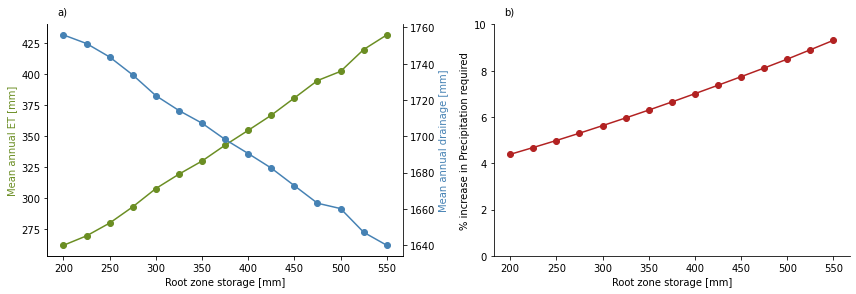

In [17]:

rzchangedf = pd.DataFrame.from_dict({'rzstore':list(range(200,575,25)),
                       'ET':etvals,
                        'd':dvals,
                       'PrecipError':perrs})


fig,axs = plt.subplots(1,2,figsize = (12,4))
ax = axs[0]
ax.plot(rzchangedf.rzstore,rzchangedf.ET,label='ET',c='olivedrab',marker='o')
ax1=ax.twinx()
ax1.plot(rzchangedf.rzstore,rzchangedf.d,label='drainage',c='steelblue',marker='o')
ax.set_ylabel('Mean annual ET [mm]',c='olivedrab')
ax1.set_ylabel('Mean annual drainage [mm]',c='steelblue')
ax.set_xlabel('Root zone storage [mm]')
for ax in [ax,ax1]:
    ax.spines['top'].set_visible(False)


ax = axs[1]
ax.plot(rzchangedf.rzstore,rzchangedf.PrecipError*100,
        marker='o',c='firebrick')
ax.set_ylim(0,10)
ax.set_ylabel('% increase in Precipitation required')
ax.set_xlabel('Root zone storage [mm]')

fig.tight_layout()

labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)',
         'j)','k)','l)','m)','n)','o)','p)','q)','r)',
          's)','t)','u)','v)']
for i,ax in enumerate(axs.flatten()):
    for side in ['top','right']:
        ax.spines[side].set_visible(False)

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0, 1.1, labels[i], transform=ax.transAxes + trans,
             verticalalignment='top', )
plt.savefig('rzstorage_sensitivity.png',format='png',dpi=300,bbox_inches='tight')

rzchangedf

Number of ports: 2
To meet mass balance, increased overall P by  4 %
270.05141089532833 18164.21012013992
Number of ports: 3
To meet mass balance, increased overall P by  5 %
295.2045566865443 19291.480239040025
Number of ports: 4
To meet mass balance, increased overall P by  6 %
326.70771280713075 21610.347659654122
Number of ports: 5
To meet mass balance, increased overall P by  6 %
336.30992840628016 22160.38841749568
Number of ports: 6
To meet mass balance, increased overall P by  7 %
357.3507022899544 23525.342855899817
Number of ports: 7
To meet mass balance, increased overall P by  7 %
374.3239664580765 24210.70886014018


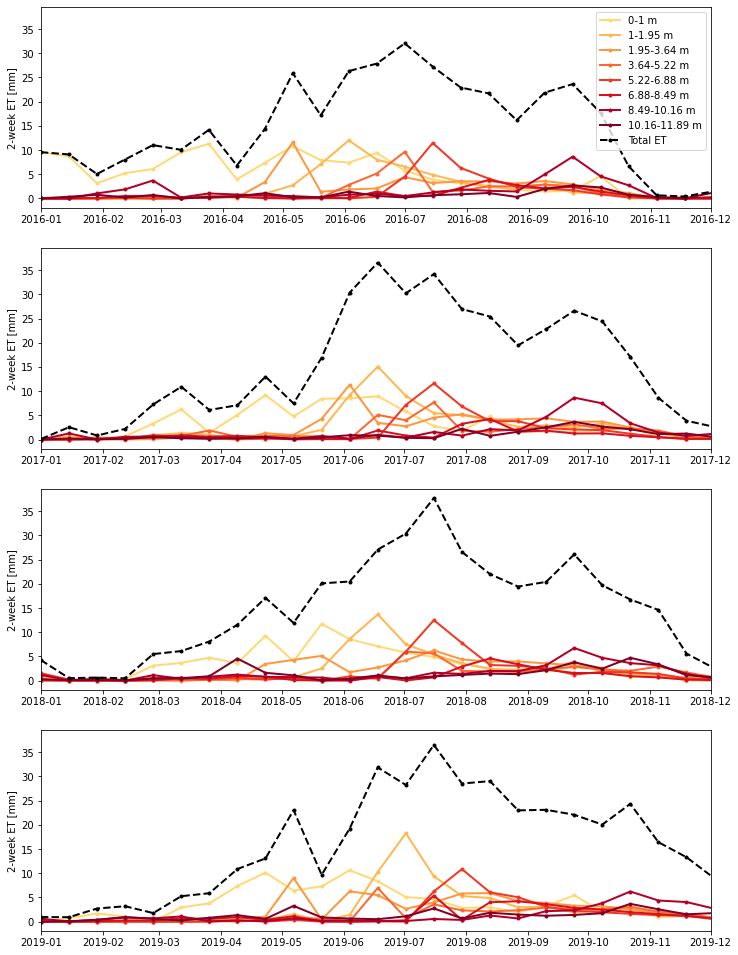

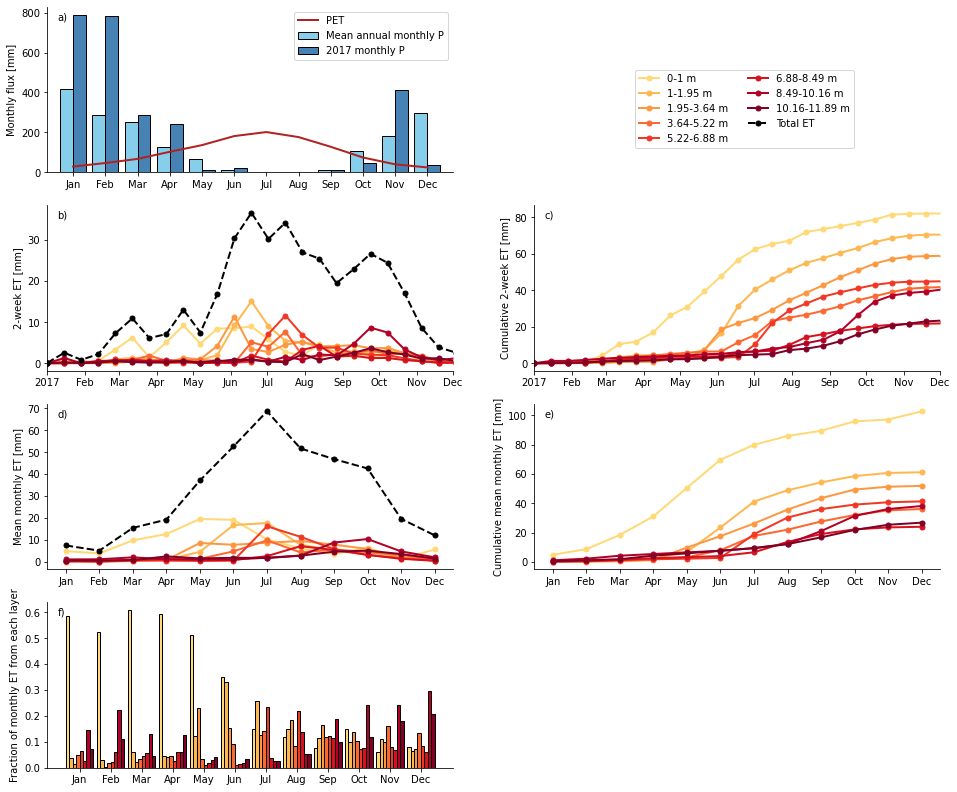

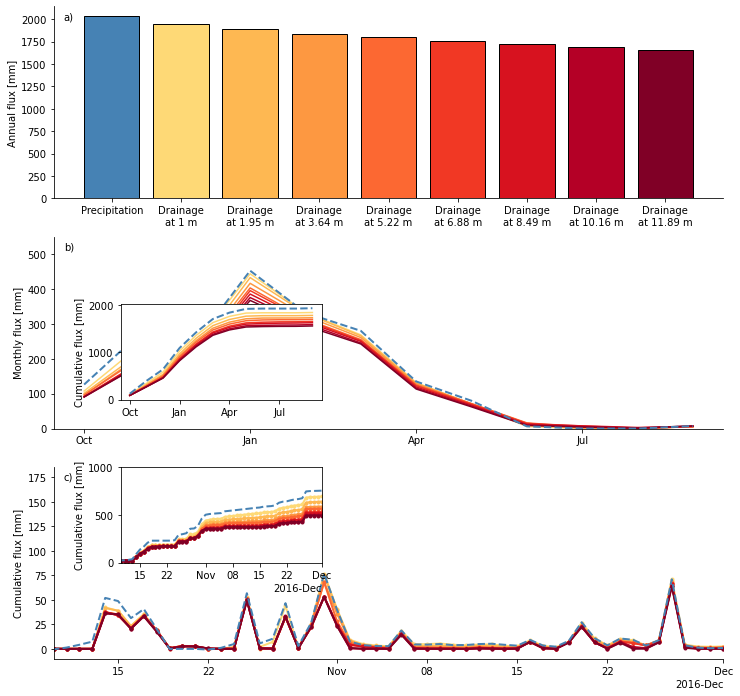

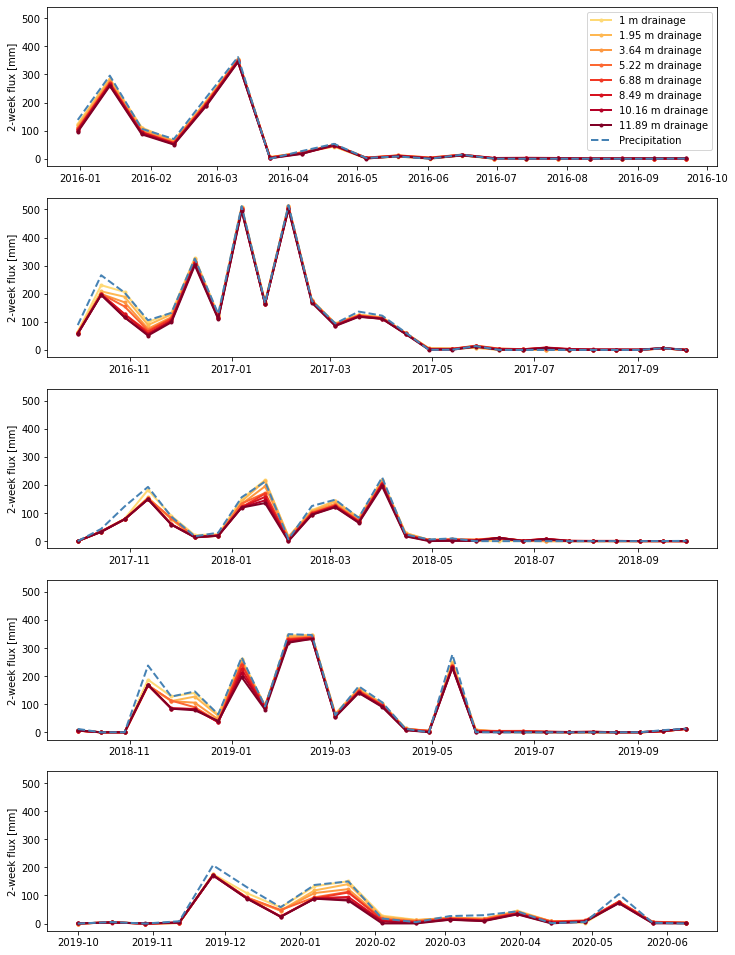

In [20]:
# run mass balance technique for all possible maximum depths

all_outputs = []
rdstore = 400

for num_ports in range(2,8):
    print('Number of ports:',num_ports)

    pet,popt,tdtData,tdr_norm,rainData = import_data(num_ports)
    Storages = setup_storage(popt,tdtData,tdr_norm,rdstore,num_ports,'exp')
    DeltaStorage = calc_deltastorage(Storages,rainData)
    DeltaStorage = calc_massbalance(DeltaStorage)
    if num_ports==7:
        make_plots(DeltaStorage)

    DS_sub = DeltaStorage.loc['2016-10-01':'2019-10-01']

    print(DS_sub.ET_total.mean()*365,
          DeltaStorage.ET_total.mean()*365/DeltaStorage.Jadjust.mean()*365)
    
    all_outputs.append(DeltaStorage)



In [21]:
# make a cumulative rainfall column for each water year

Jcum = []
for wy in DeltaStorage.wy.unique():
    wysub = DeltaStorage[DeltaStorage.wy==wy]
    Jcum.append(wysub.Jadjust.cumsum())
Jcum = pd.concat(Jcum)
DeltaStorage['Jcum'] = Jcum

In [31]:
###############
# mass balance calcs

streamflow = pd.read_csv('../Data/Elder_streamflow.txt',sep='\t').iloc[1:]
streamflow['Q_m3/s'] = streamflow['16502_00060'].astype('float')*12**3*2.54**3/100**3
streamflow['datetime'] = pd.to_datetime(streamflow.datetime)
streamflow.set_index('datetime',inplace=True)
streamflow['Q_mm/d'] = streamflow['Q_m3/s']*60*60*24/(16.853*1000**2)*1000
Q_mm_yr = streamflow['Q_mm/d'].mean()*365
d_mm_yr = DeltaStorage.loc['2016-10-01':'2019-10-01'].mean().d7*365
J_mm_yr = (rainData.loc['2016-10-10':'2019-10-01']['J [mm/h]'].mean()*365*24)
print('Mean annual ET from mass balance: ',(J_mm_yr*.8-Q_mm_yr),'-',(J_mm_yr*.9-Q_mm_yr))
print('Q',Q_mm_yr,', drainage',d_mm_yr,', difference of ',d_mm_yr-Q_mm_yr)


Mean annual ET from mass balance:  530.2609218990276 - 785.8952365264424
Q 1514.813595120292 , drainage 1888.877571440597 , difference of  374.0639763203051


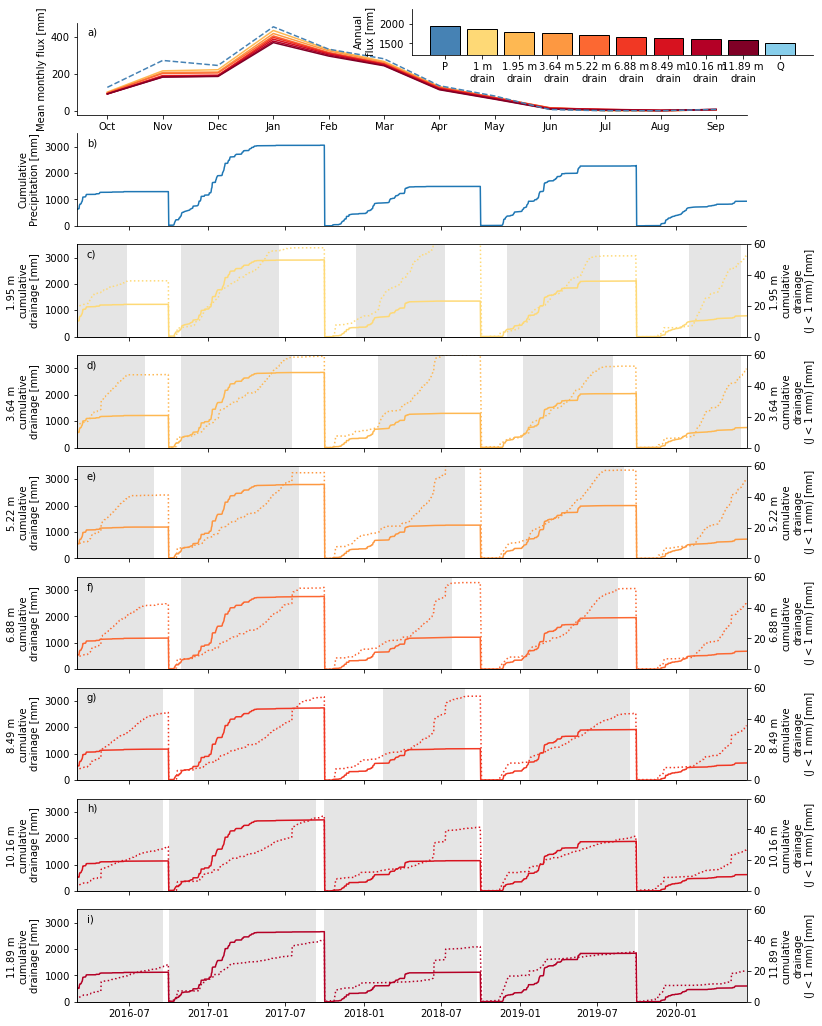

In [33]:
# plot drainage results with sample dates
colors = pl.cm.YlOrRd(np.linspace(0.25,1,num_ports+1))

import datetime
fig,axs = plt.subplots(9,figsize = (12,20),)
DeltaStorage['month'] = DeltaStorage.index.month

ax = axs[0]
DSmonth = DeltaStorage.groupby('month').mean()*30
DSmonth = pd.concat([DSmonth.loc[10:],DSmonth.loc[:9]])
for i in range(1,num_ports+1):
    ax.plot(DSmonth.index.astype('str'),DSmonth['d'+str(i)],
           c = colors[i],)
ax.plot(DSmonth.index.astype('str'),
       DSmonth.Jadjust,c='steelblue',ls='--',label = 'P')
ax.set_ylabel('Mean monthly flux [mm]')
ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr',
                  'May','Jun','Jul','Aug','Sep'])

axins = ax.inset_axes([.5,.65,.6,.5])
DSannual = DSmonth[['Jadjust']+['d'+str(i) for i in range(num_ports+1)]].mean()/30*365
for i in range(len(DSannual)):
    axins.bar([i],
          [DSannual.values[i]],
           facecolor = (['steelblue']+list(colors))[i],
             edgecolor = 'k')
axins.bar([i+1],[Q_mm_yr],facecolor = 'skyblue',edgecolor = 'k')
axins.set_xticks(list(range(len(DSannual)+1)))
axins.set_xticklabels(['P']+[str(([1]+port_depths)[i])+' m\ndrain' for i in range(num_ports+1)]+['Q'])
axins.set_ylabel('Annual\nflux [mm]')
axins.spines[['top','right']].set_visible(False)
axins.set_ylim(1200,2400)

ax = axs[1]
DeltaStorage.Jcum.plot(ax=ax)
ax.set_xlim(pd.to_datetime(DeltaStorage.index.values[0])+datetime.timedelta(60),
                DeltaStorage.index.values[-1])
ax.set_xticklabels([])
ax.set_ylabel('Cumulative\nPrecipitation [mm]')
ax.set_ylim(0,3500)

for i in range(7):
    ax = axs[i+2]
    dscum = []
    dmincum = []
    for yr in DeltaStorage.wy.unique():
        subset = DeltaStorage[(DeltaStorage.wy==yr)]
        subset1 = DeltaStorage[(DeltaStorage.wy==yr) & (DeltaStorage.Jadjust<1)]
        dscum.append(subset['d'+str(i+1)].cumsum())
        dmincum.append(subset1['d'+str(i+1)].cumsum())
    dscum = pd.concat(dscum)
    dmincum = pd.concat(dmincum)
    ax.plot(dscum,
                c=colors[i])
    axtwin = ax.twinx()
    axtwin.plot(dmincum,
            c=colors[i],ls=':')
    ax.set_ylabel(str(port_depths[i])+' m \ncumulative\ndrainage [mm]')
    axtwin.set_ylabel(str(port_depths[i])+' m \ncumulative\ndrainage\n(J < 1 mm) [mm]')
    if i<6:
        ax.set_xticklabels([])
    ax.set_xlim(pd.to_datetime(DeltaStorage.index.values[0])+datetime.timedelta(60),
                DeltaStorage.index.values[-1])
    ax.set_ylim(0,3500)
    axtwin.set_ylim(0,60)
    

    dat = first_last_dates_water_year[first_last_dates_water_year['Location']=='A'+str(i+1)]
    for _, row in dat.iterrows():
        ax.axvspan(row['Last Date'], row['First Date']-datetime.timedelta(7), 
                   alpha=.1,facecolor='k')

labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)',
         'j)','k)','l)','m)','n)','o)','p)','q)','r)',
          's)','t)','u)','v)']
for i,ax in enumerate(axs.flatten()):
    for side in ['top','right']:
        ax.spines[side].set_visible(False)

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0, 1., labels[i], transform=ax.transAxes + trans,
             verticalalignment='top', )
    
plt.savefig('drainage_align_samples.png',format='png',dpi=300,bbox_inches='tight')

In [34]:
# label three seasons, approximately winter, spring, and summer
# but names just used for labeling purposes

DeltaStorage['season'] = np.where(DeltaStorage.month.isin([10,11,12,1]),
                                 'winter',np.nan)
DeltaStorage['season'] = np.where(DeltaStorage.month.isin([2,3,4,5]),
                                 'spring',DeltaStorage.season)
DeltaStorage['season'] = np.where(DeltaStorage.month.isin([6,7,8,9]),
                                 'summer',DeltaStorage.season)

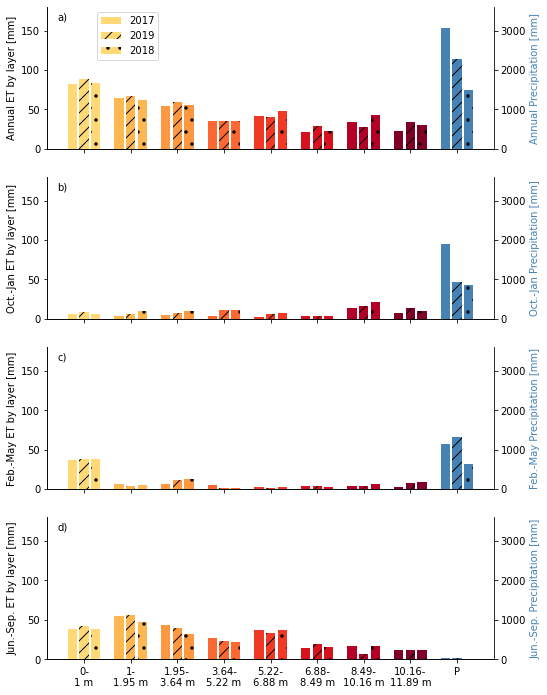

In [35]:
# compare ET magnitudes at different depths annually and seasonally
# for three water years with different precipitation

yrsums = DeltaStorage.groupby('wy').sum().iloc[1:-1][['Jadjust']+['ET'+str(i) for i in range(num_ports,-1,-1)]]
seasonsums = DeltaStorage.groupby(['wy','season']).sum()[['Jadjust']+['ET'+str(i) for i in range(num_ports,-1,-1)]]

fig,axs = plt.subplots(4,figsize = (8,12),sharex=True,sharey=True)
yrs = [2017,2019,2018]
hatches = ['','//','.']


ax = axs[1-1]
axt = ax.twinx()
axt.spines['top'].set_visible(False)
axt.set_ylabel('Annual Precipitation [mm]',c='steelblue')
for j,yr in enumerate(yrs):
    for i in range((num_ports+1)):
        if i==0:
            lab = yr
        else:
            lab = None
        ax.bar(i-.25+j/4,yrsums['ET'+str(i)].loc[yr],
              facecolor = colors[i],width = .2,hatch=hatches[j],label=lab)
    MAP = yrsums.Jadjust.loc[yr]
    yloc = yrsums.ET0.loc[yr]
    axt.bar(i+1-.25+j/4,yrsums.Jadjust.loc[yr],
           width = .2,facecolor = 'steelblue',hatch = hatches[j])
    axt.set_ylim(0,3600)
ax.set_xticks(list(range(num_ports+2)))
ax.set_xticklabels([str(([0,1]+port_depths)[i])+'-\n'+
                   str(([0,1]+port_depths)[i+1])+' m' for i in range(num_ports+1)]+['P'])
ax.set_ylabel('Annual ET by layer [mm]')
ax.legend(loc='upper left',bbox_to_anchor = (.1,1))

months = ['Oct.-Jan','Feb.-May','Jun.-Sep.']
for k,season in enumerate(['winter','spring','summer']):
    ax = axs[2+k-1]
    axt = ax.twinx()
    for j,yr in enumerate(yrs):
        for i in range((num_ports+1)):
            ax.bar(i-.25+j/4,seasonsums['ET'+str(i)].loc[yr,season],
                  facecolor = colors[i],width = .2,hatch=hatches[j])
        axt.bar(i+1-.25+j/4,seasonsums.Jadjust.loc[yr,season],
           width = .2,facecolor = 'steelblue',hatch=hatches[j],label=lab)
    ax.set_ylabel(months[k]+' ET by layer [mm]')
    ax.set_ylim(0,180)
    axt.set_ylim(0,3600)
    axt.spines[['top',]].set_visible(False)
    axt.set_ylabel(months[k]+' Precipitation [mm]',c='steelblue')
    
for ax in axs:
    ax.spines[['top','right']].set_visible(False)
    
labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)',
         'j)','k)','l)','m)','n)','o)','p)','q)','r)',
          's)','t)','u)','v)']
for i,ax in enumerate(axs.flatten()):
    for side in ['top','right']:
        ax.spines[side].set_visible(False)

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0, 1., labels[i], transform=ax.transAxes + trans,
             verticalalignment='top', )
    
plt.savefig('et_p_seasons.png',format='png',dpi=300,bbox_inches='tight')

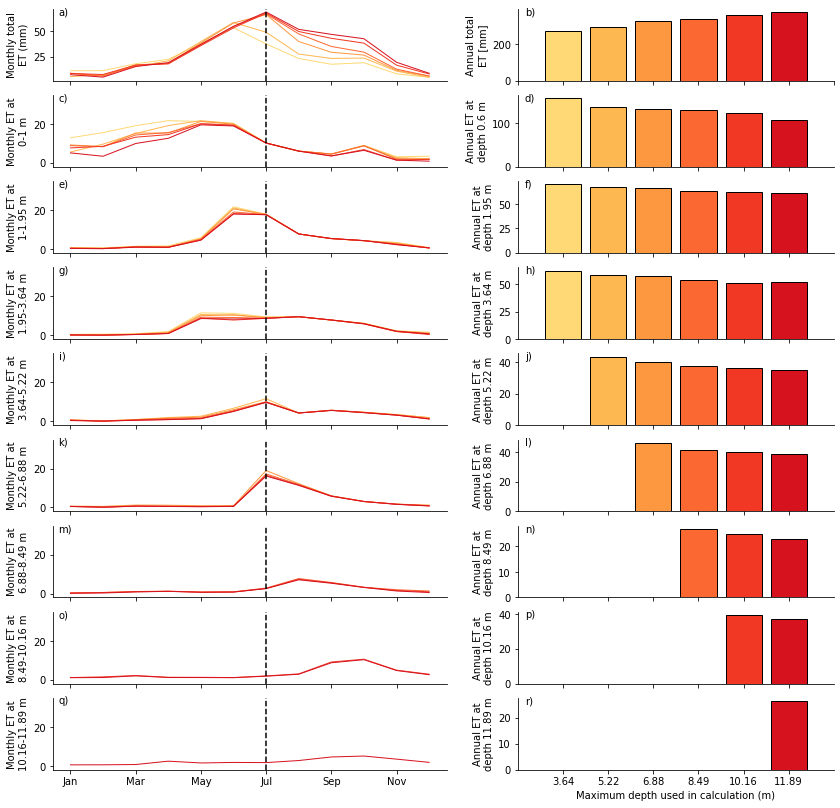

In [37]:
# plot timing of mean annual ET patterns
# and how maximum depth affects this

fig,axs = plt.subplots(9,2,figsize = (14,14),
                      gridspec_kw={'width_ratios':[5,4]})

colors = pl.cm.YlOrRd(np.linspace(0.25,1,num_ports+1))

ax = axs[0,0]
for i in range(len(all_outputs)):
    DS = all_outputs[i]
    DS['month'] = DS.index.month
    DS = DS.groupby('month').mean()*30
    if i==4:
        lw = 1#3
        ls = 'solid'#':'
    else:
        lw = 1
        ls = 'solid'
    ax.plot(DS.index,
            DS.ET_total,label='Max. depth: '+str(port_depths[i+1])+' m',c=colors[i],
           lw = lw, ls = ls)
# ax.legend(loc = 'upper left',bbox_to_anchor = (.05,1.4))
ax.set_ylabel('Monthly total\nET (mm)')
ax.set_xticks([1,3,5,7,9,11])
ax.set_xticklabels([])
ax.axvline(7,c='k',ls='--')

ax = axs[0,1]
for i in range(len(all_outputs)):
#     print (i)
    DS = all_outputs[i].loc['2016-10-01':'2019-10-01'].mean()*365
    if i==4:
        lw = 1#3
    else:
        lw = 1
    ax.bar([i+2],[DS.ET_total],edgecolor = 'k',facecolor = colors[i],lw=lw)
ax.set_xticklabels([])
ax.set_xlim(1,8)
ax.set_ylabel('Annual total\nET [mm]')

for port in range(8):
    ax = axs[port+1,0]
    for i in range(len(all_outputs)):
        DS = all_outputs[i]
        DS['month'] = DS.index.month
        DS = DS.groupby('month').mean()*30
        if i==4:
            lw = 1#3
            ls = 'solid'#':'
        else:
            lw = 1
            ls = 'solid'
        try:
            ax.plot(DS.index,
                DS['ET'+str(port)],
                label=i+2,c=colors[i],lw = lw,ls=ls)
        except:
            continue
    if port==0:
        portdepth = 1
        lownum = 0
    elif port==1:
        lownum = 1
        portdepth = port_depths[port-1]
    else:
        lownum = portdepth
        portdepth = port_depths[port-1]

    ax.set_ylabel('Monthly ET at\n'+str(lownum)+'-'+str(portdepth)+' m')
    ax.set_ylim(-2,35)
    ax.axvline(7,c='k',ls='--')
    ax.set_xticks([1,3,5,7,9,11])
    ax.set_xticklabels([])
    
    
ax.set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov']) 
    
for port in range(8):
    ax = axs[port+1,1]
    for i in range(len(all_outputs)):
        DS = all_outputs[i].mean()*365
        if i==4:
            lw = 1#3
        else:
            lw = 1
        try:
            ax.bar([i+2],[DS['ET'+str(port)]],edgecolor = 'k',facecolor = colors[i],lw=lw)
        except:
            continue
    portdepth = port_depths[port-1]
    if port==0:
        portdepth = 0.6
    ax.set_ylabel('Annual ET at\ndepth '+str(portdepth)+' m')
    ax.set_xlim(1,8)
    ax.set_xticks(list(range(2,8)))
    ax.set_xticklabels([])
#     ax.set_ylim(0,360)
ax.set_xticklabels([port_depths[i-1] for i in list(range(2,8))])
ax.set_xlabel('Maximum depth used in calculation (m)')


labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)',
         'j)','k)','l)','m)','n)','o)','p)','q)','r)',
          's)','t)','u)','v)']
for i,ax in enumerate(axs.flatten()):
    for side in ['top','right']:
        ax.spines[side].set_visible(False)

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(-.01, 1.1, labels[i], transform=ax.transAxes + trans,
             verticalalignment='top', )
    
plt.savefig('compare_numports.png',fmt='png',dpi=300,bbox_inches='tight')

Text(0, 0.5, 'Mean annual ET [mm]')

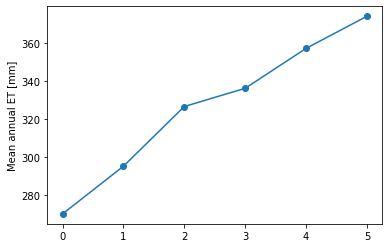

In [43]:
# plot mean annual ET as a function of maximal depth
etsums = []
for i in range(len(all_outputs)):
    etsums.append(all_outputs[i].loc['2016-10-01':'2019-10-01'].ET_total.mean()*365,
                 )
plt.plot(etsums,marker = 'o')
plt.ylabel('Mean annual ET [mm]')


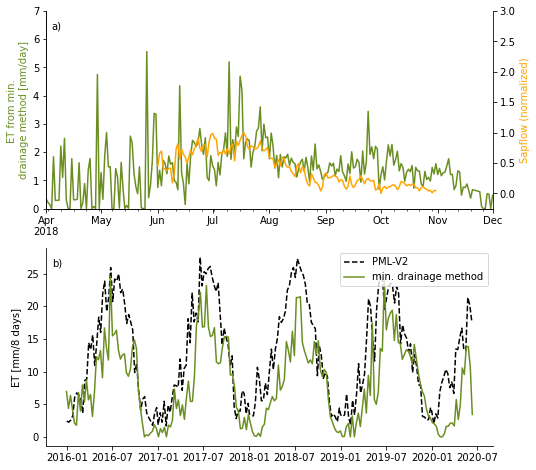

In [307]:
fig,axs = plt.subplots(2,figsize = (8,8
                                  ))

ax = axs[0]
axt = ax.twinx()
sapflownorm.mean(axis=1).plot(ax=axt,label='Sapflow',c='orange')

DeltaStorage.ET_total.loc['2018-04-01':'2018-12-01'].plot(ax=ax,label='ET',
                                                         c='olivedrab')
# plt.legend()
ax.set_ylim(0,7)
ax.set_ylabel('ET from min. \ndrainage method [mm/day]',c='olivedrab')
axt.set_ylim(-.25,3)
axt.set_ylabel('Sapflow (normalized)', c = 'orange')


ax = axs[1]
ElderPML = pd.read_csv('ElderPML.csv',header=None).rename(columns={0:'date',1:'ET_PML'})
ElderPML['date'] = pd.to_datetime(ElderPML['date'])
ElderPML.set_index('date',inplace=True)
ElderPML = ElderPML.loc[DeltaStorage.index.values[0]:DeltaStorage.index.values[-1]]
axt2 = ax#.twinx()
axt2.plot(ElderPML.index,ElderPML.ET_PML,c='k',label='PML-V2',ls='--')
DS8day = DeltaStorage.ET_total.resample('8D').sum()
ax.plot(DS8day.index,DS8day,c='olivedrab',label='min. drainage method')
ax.legend()
axt2.set_ylabel('ET from PML-V2 [mm/8 days]')
ax.set_ylabel('ET [mm/8 days]')#,c='olivedrab')

for ax in axs:
    ax.spines[['top','right']].set_visible(False)
for ax in [axt,axt2]:
    ax.spines['top'].set_visible(False)

labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)',
         'j)','k)','l)','m)','n)','o)','p)','q)','r)',
          's)','t)','u)','v)']
for i,ax in enumerate(axs.flatten()):
    for side in ['top','right']:
        ax.spines[side].set_visible(False)

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(-.01, .975, labels[i], transform=ax.transAxes + trans,
             verticalalignment='top', )
    
plt.savefig('ET_compare.png',fmt='png',dpi=300,bbox_inches='tight')

In [303]:
annualmeans = DeltaStorage.loc['2016-10-01':'2019-10-01'].mean()*365
(annualmeans.ET0)/annualmeans.ET_total
annualmeans.d7#-Q_mm_yr
(annualmeans.ET0+annualmeans.ET1)/annualmeans.ET_total

0.42162456463627

In [308]:
annualmeans.d7

1888.877571440597

In [288]:
Q_mm_yr,annualmeans.ET_total,annualmeans.Jadjust

(1514.813595120292, 374.3239664580765, 2292.377868869452)

In [289]:
(rainData['J [mm/h]'].loc['2016-10-01':'2019-10-01'].mean()*365*24)#*.9-Q_mm_yr

2546.874087591241

In [290]:
annual

509.40000000000003

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Text(0, 0.5, 'Total monthly ET from column ')

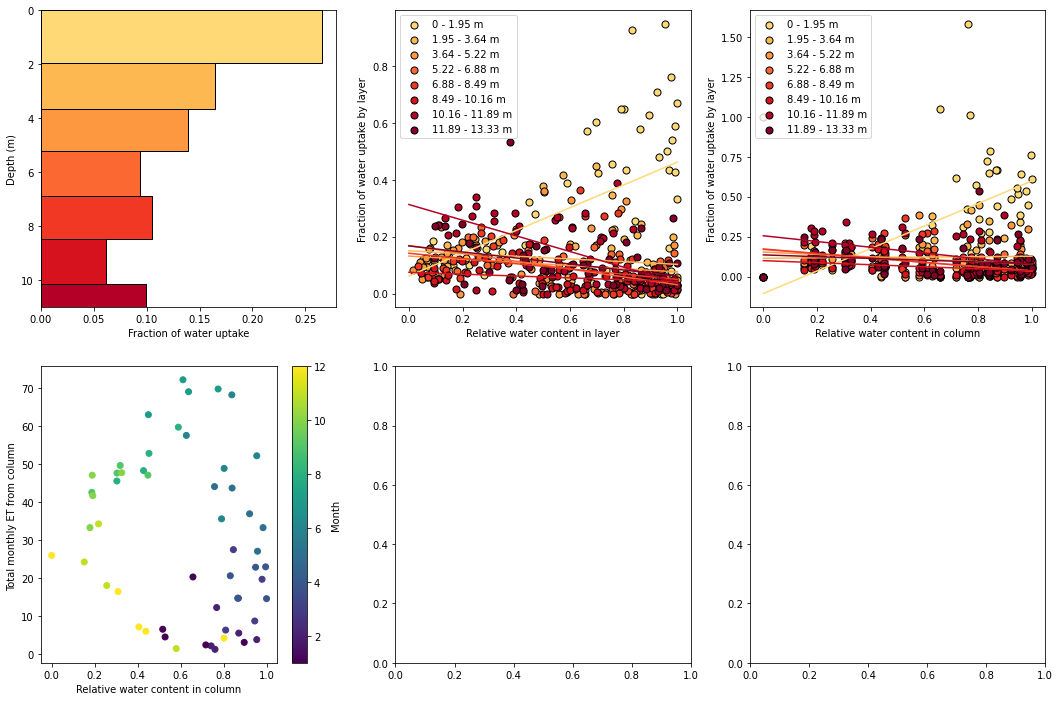

In [291]:
alloutputnum = 5
portnum = 7

def fun(x,a,b):
    return(a*x+b)

colors = pl.cm.YlOrRd(np.linspace(0.25,1,portnum+1))
DeltaStorage_plot = all_outputs[alloutputnum]

uptake_distribution = DeltaStorage_plot.sum()[['ET'+str(l) for l in range(portnum+1)]]
uptake_distribution = uptake_distribution/uptake_distribution.sum()

fig,axs = plt.subplots(2,3,figsize = (18,12))

ax = axs[0,0]
port_widths = [port_depths[0]]+list(np.array(port_depths[1:portnum+1])-np.array(port_depths[:portnum]))

for i in range(portnum+1):
    ax.barh([(np.array([0]+port_depths[:portnum])+np.array(port_widths)/2)[i]],
            [uptake_distribution[i]],
            height = port_widths[i],
            facecolor = colors[i],
           edgecolor = 'k')
ax.set_xlabel('Fraction of water uptake')
ax.set_ylabel('Depth (m)')
ax.set_ylim(11,0)

ax = axs[0,1]
DeltaStorage_plot['SA0'] = DeltaStorage_plot['SSoil']
DS_month = DeltaStorage_plot.resample('M').sum()[['ET'+str(i) for i in range(portnum+1)]+['ET_total']]
DS_monthS = DeltaStorage_plot.resample('M').mean()[['SA'+str(i) for i in range(portnum+1)]]
DS_month = DS_month.merge(DS_monthS,left_index=True,right_index=True)


for i in range(portnum+1):
    DS_month['ET'+str(i)+'_norm'] = DS_month['ET'+str(i)]/DS_month.ET_total
    ax.scatter(DS_month['SA'+str(i)]/DS_month['SA'+str(i)].max(),
               DS_month['ET'+str(i)+'_norm'],
               s=50,
               edgecolor = 'k',
               c = colors[i],
              label = str(([0]+port_depths)[i])+' - '+str(port_depths[i])+' m')
    
    popt, pcov = curve_fit(fun, 
                           (DS_month['SA'+str(i)]/DS_month['SA'+str(i)].max()).values[1:],
                          DS_month['ET'+str(i)+'_norm'].values[1:] )
    xv = np.linspace(0,1)
    ax.plot(xv,fun(xv,*popt),c=colors[i])
    
ax.set_xlabel('Relative water content in layer')
ax.set_ylabel('Fraction of water uptake by layer')
ax.legend()

ax = axs[0,2]
DeltaStorage_plot['SA0'] = DeltaStorage_plot['SSoil']
DS_month = DeltaStorage_plot.resample('M').mean()[['ET'+str(i) for i in range(portnum+1)]+['ET_total','PET_mmd']]*30
DS_monthS = DeltaStorage_plot.resample('M').mean()[['SA'+str(i) for i in range(portnum+1)]]
DS_month = DS_month.merge(DS_monthS,left_index=True,right_index=True)


relstorage_VMS = (DS_month[['SA'+str(i) for i in range(portnum+1)]].sum(axis=1))
relstorage_VMS = relstorage_VMS/relstorage_VMS.max()

for i in range(portnum+1):
    DS_month['ET'+str(i)+'_norm'] = DS_month['ET'+str(i)]/DS_month.ET_total
    ax.scatter(relstorage_VMS,
               DS_month['ET'+str(i)+'_norm'],
               s=50,
               edgecolor = 'k',
               c = colors[i],
              label = str(([0]+port_depths)[i])+' - '+str(port_depths[i])+' m')
    
    popt, pcov = curve_fit(fun, 
                           relstorage_VMS.values[1:],
                          DS_month['ET'+str(i)+'_norm'].values[1:] )
    xv = np.linspace(0,1)
    ax.plot(xv,fun(xv,*popt),c=colors[i])
    
ax.set_xlabel('Relative water content in column')
ax.set_ylabel('Fraction of water uptake by layer')
ax.legend()

ax = axs[1,0]

im = ax.scatter(relstorage_VMS,DS_month.ET_total,
          c=DS_month.reset_index()['index'].dt.month)

cbar = plt.colorbar(im,ax=ax)
cbar.set_label('Month')
ax.set_xlabel('Relative water content in column')
ax.set_ylabel('Total monthly ET from column ')

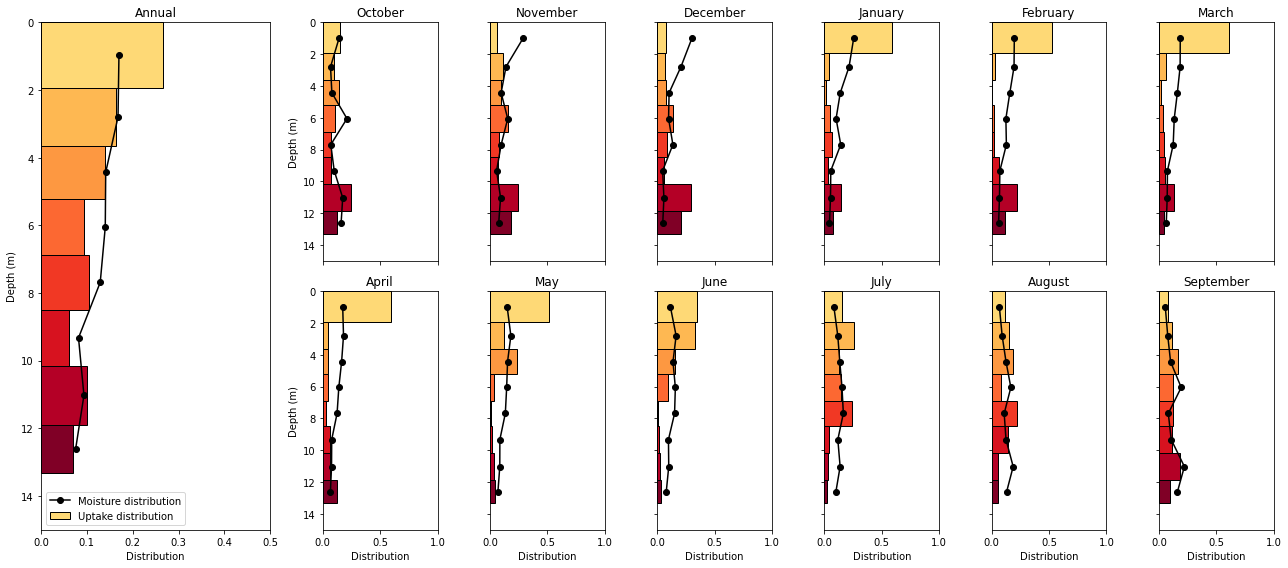

In [292]:
# alloutputnum = 4
# portnum = 5

def fun(x,a,b):
    return(a*x+b)

colors = pl.cm.YlOrRd(np.linspace(0.25,1,portnum+1))
DeltaStorage_plot = all_outputs[alloutputnum]

uptake_distribution = DeltaStorage_plot.sum()[['ET'+str(l) for l in range(portnum+1)]]
uptake_distribution = uptake_distribution/uptake_distribution.sum()


fig = plt.figure(constrained_layout=True, figsize = (18,8),
                )
spec = gridspec.GridSpec(ncols=7, nrows=2, figure=fig, width_ratios=[2,]+[1]*6)

annualax = fig.add_subplot(spec[:, 0]) # this is annual
axs = []
for j in range(2):
    for i in range(6):
        axs.append(fig.add_subplot(spec[j,i+1]))


ax = annualax
port_widths = [port_depths[0]]+list(np.array(port_depths[1:portnum+1])-np.array(port_depths[:portnum]))
moisturedist = DeltaStorage_plot[['SA'+str(i) for i in range(portnum+1)]].dropna().mean()
moisturedist = moisturedist/moisturedist.sum()

for i in range(portnum+1):
    if i==0:
        label = 'Uptake distribution'
    else:
        label = None
    ax.barh([(np.array([0]+port_depths[:portnum])+np.array(port_widths)/2)[i]],
            [uptake_distribution[i]],
            height = port_widths[i],
            facecolor = colors[i],
           edgecolor = 'k',
           label = label)
ax.plot(moisturedist.values,
           (np.array([0]+port_depths[:portnum])+np.array(port_widths)/2),
           c='k',marker='o',
       label = 'Moisture distribution')
ax.set_ylabel('Depth (m)')
ax.set_title('Annual')
ax.legend()

monthnames = ['October','November','December',
             'January','February','March','April',
             'May','June','July','August','September']
for j,month in enumerate([10,11,12,1,2,3,4,5,6,7,8,9]):
    ax = axs[j]
    DeltaStorage_month = DeltaStorage_plot[DeltaStorage_plot.reset_index()['index'].dt.month.values==month]
    uptake_distribution = DeltaStorage_month.sum()[['ET'+str(l) for l in range(portnum+1)]]
    uptake_distribution = uptake_distribution/uptake_distribution.sum()
    
    moisturedist = DeltaStorage_month[['SA'+str(i) for i in range(portnum+1)]].dropna().mean()
    moisturedist = moisturedist/moisturedist.sum()

    for i in range(portnum+1):
        ax.barh([(np.array([0]+port_depths[:portnum])+np.array(port_widths)/2)[i]],
                [uptake_distribution[i]],
                height = port_widths[i],
                facecolor = colors[i],
               edgecolor = 'k')
    ax.plot(moisturedist.values,
           (np.array([0]+port_depths[:portnum])+np.array(port_widths)/2),
           c='k',marker='o')
    ax.set_title(monthnames[j])
    if j>5:
        ax.set_xlabel('Distribution')
    else:
        ax.set_xticklabels([])
    if j in [0,6]:
        ax.set_ylabel('Depth (m)')
    else:
        ax.set_yticklabels([])
        
# axs[1,0].set_ylabel('Depth (m)')
for ax in axs+[annualax]:
    ax.set_ylim(15,0)
    ax.set_xlim(0,1)
annualax.set_xlim(0,.5)
annualax.set_xlabel('Distribution')
    
fig.tight_layout()

<AxesSubplot:>

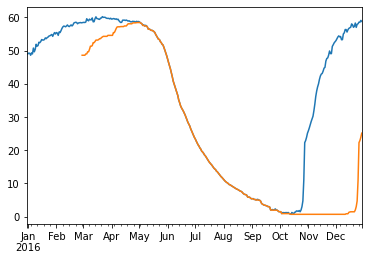

In [293]:
DeltaStorage.SA1.iloc[:365].plot()
DeltaStorage.rolling(60,center=False).min().SA1.iloc[:365].plot()

In [294]:
frac = 1
frac1 = .75
rollnum = 90
# petthresh = .5
petfrac = 1/(portnum+1)

condition = (DeltaStorage_plot.SSoil.rolling(rollnum,center=False).quantile(.25)<DeltaStorage_plot.SSoil.max()*frac1)
DeltaStorage_plot['ETtab0'] = np.where(condition,
                                  DeltaStorage_plot.ET_total*petfrac,
                                  np.nan)

    
DeltaStorage_plot['ETtab0'] = np.where((DeltaStorage_plot.SSoil>=DeltaStorage_plot.SSoil.max()*frac) &
                                    (DeltaStorage_plot.SSoil>=DeltaStorage_plot.ET_total) &
                                  ~condition,
                                  DeltaStorage_plot.ET_total,
                                  DeltaStorage_plot.ETtab0)
DeltaStorage_plot['ETtab0'] = np.where((DeltaStorage_plot.SSoil>=DeltaStorage_plot.SSoil.max()*frac) &
                                    (DeltaStorage_plot.SSoil<DeltaStorage_plot.ET_total) &
                                  ~condition,
                                  DeltaStorage_plot.SSoil,
                                  DeltaStorage_plot.ETtab0)
DeltaStorage_plot['ETtab0'] = np.where((DeltaStorage_plot.SSoil<DeltaStorage_plot.SSoil.max()*frac) &
                                  ~condition,
                                  DeltaStorage_plot.ET_total*DeltaStorage_plot.SSoil/DeltaStorage_plot.SSoil.max(),
                                  DeltaStorage_plot.ETtab0)

ETdivide = DeltaStorage_plot.ET_total-DeltaStorage_plot.ETtab0

for i in range(1,portnum+1):
    condition1 = (DeltaStorage_plot['SA'+str(i)].rolling(rollnum,center=False).quantile(.25)<DeltaStorage_plot['SA'+str(i)].max()*frac1)

    DeltaStorage_plot['ETtab'+str(i)] = np.where(condition1,
                                  ETdivide*petfrac,
                                  np.nan)



for i in range(1,portnum+1):
    condition1 = (DeltaStorage_plot['SA'+str(i)].rolling(rollnum,center=False).quantile(.25)<DeltaStorage_plot['SA'+str(i)].max()*frac1)

    DeltaStorage_plot['ETtab'+str(i)] = np.where((DeltaStorage_plot['SA'+str(i)]>=DeltaStorage_plot['SA'+str(i)].max()*frac) &
                                    (DeltaStorage_plot['SA'+str(i)]>=ETdivide) &
                                  ~condition1,
                                  ETdivide,
                                  DeltaStorage_plot['ETtab'+str(i)])
    DeltaStorage_plot['ETtab'+str(i)] = np.where((DeltaStorage_plot['SA'+str(i)]>=DeltaStorage['SA'+str(i)].max()*frac) &
                                        (DeltaStorage_plot['SA'+str(i)]<ETdivide) &
                                  ~condition1,
                                      DeltaStorage_plot['SA'+str(i)],
                                      DeltaStorage_plot['ETtab'+str(i)])
    DeltaStorage_plot['ETtab'+str(i)] = np.where((DeltaStorage_plot['SA'+str(i)]<DeltaStorage_plot['SA'+str(i)].max()*frac) &
                                  ~condition1,
                                      ETdivide*DeltaStorage_plot['SA'+str(i)]/DeltaStorage_plot['SA'+str(i)].max(),
                                      DeltaStorage_plot['ETtab'+str(i)])

    ETdivide = ETdivide - DeltaStorage_plot['ETtab'+str(i)]
                                  

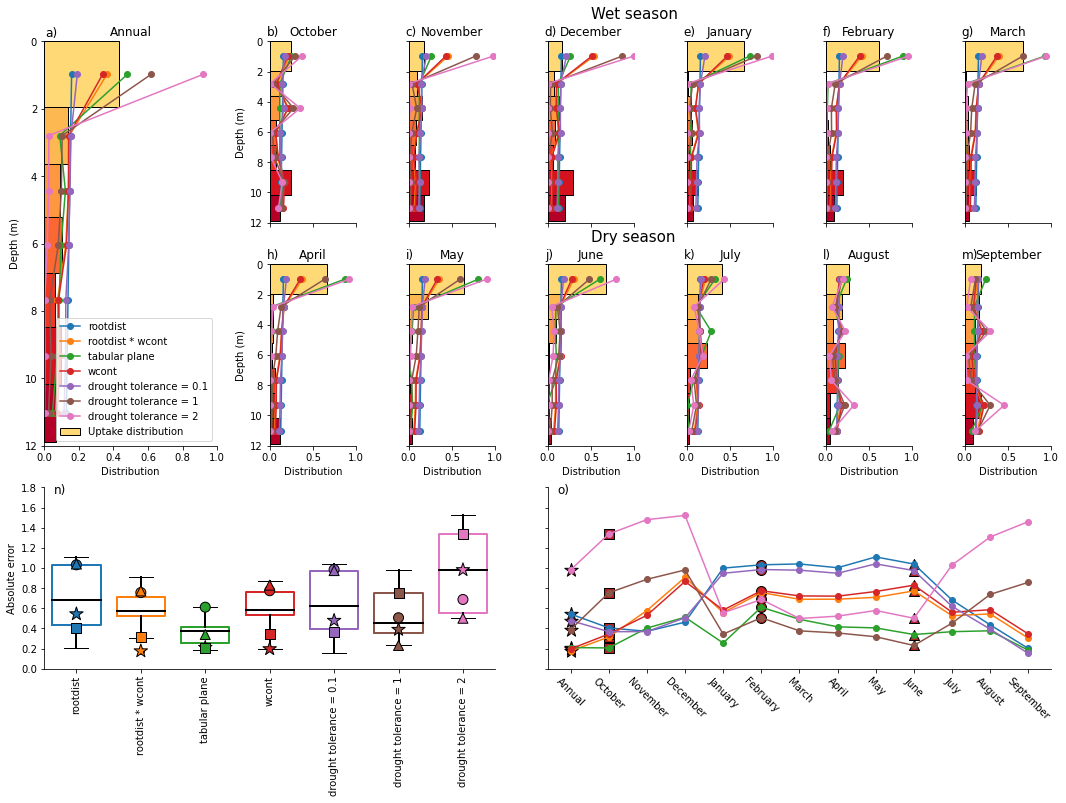

In [295]:
from scipy.stats import pearsonr
from scipy.stats import entropy
def kge(modeled, observed):
    return sum(abs(modeled-observed))
#     return np.nansum(np.log2(np.array(observed)/modeled)*np.array(observed))
    
#     newdf = pd.DataFrame.from_dict({'modeled':modeled, 'observed':observed})
#     newdf = newdf.dropna()
#     CC = pearsonr(newdf.modeled, newdf.observed)[0]
#     cm = np.nanmean(modeled)
#     rm = np.nanmean(observed)
#     cd = np.nanstd(modeled)
#     rd = np.nanstd(observed)
#     r = CC
#     alpha = cd/rd
#     beta = cm/rm
#     kge_val = 1-((r-1)**2+(alpha-1)**2+(beta-1)**2)**0.5
#     return(kge_val)#,r,alpha,beta)

performance = {key:[] for key in ['month','rdist','rdist_wcont',
                                  'tabplane',
                                 'wcont','drought0.1','drought1',
                                 'drought2',]}

fig = plt.figure(constrained_layout=True, figsize = (15,11),
                )
spec = gridspec.GridSpec(ncols=7, nrows=3, figure=fig, width_ratios=[2,]+[1]*6)

annualax = fig.add_subplot(spec[:-1, 0]) # this is annual
axs = []
for j in range(2):
    for i in range(6):
        axs.append(fig.add_subplot(spec[j,i+1]))
ax1 = fig.add_subplot(spec[2,:3])
ax2 = fig.add_subplot(spec[2,3:])

axall = [annualax,ax1,ax2]+axs
        
ax = annualax
def exp_fun(x,a,b):
    return np.exp(a*x)*b
DeltaStorage_plot = all_outputs[alloutputnum]

uptake_distribution = DeltaStorage_plot.sum()[['ET'+str(l) for l in range(portnum+1)]]
uptake_distribution = uptake_distribution/uptake_distribution.sum()
uptake_distribution.loc['ET1'] = uptake_distribution.iloc[:2].sum()
uptake_distribution = uptake_distribution.iloc[1:]
port_widths = [port_depths[0]]+list(np.array(port_depths[1:portnum])-np.array(port_depths[:portnum-1]))
moisturedist = DeltaStorage_plot[['SA'+str(i) for i in range(portnum+1)]].dropna().mean()
moisturedist = moisturedist/moisturedist.sum()
moisturedist.iloc[1] = moisturedist.iloc[:2].sum()
moisturedist = moisturedist.iloc[1:]
etdist_tab = DeltaStorage_plot[['ETtab'+str(i) for i in range(portnum+1)]].dropna().mean()
etdist_tab = etdist_tab/etdist_tab.sum()
etdist_tab.iloc[1] = etdist_tab.iloc[:2].sum()
etdist_tab = etdist_tab.iloc[1:]

for i in range(portnum):
    if i==0:
        label = 'Uptake distribution'
    else:
        label = None
    ax.barh([(np.array([0]+port_depths[:portnum-1])+np.array(port_widths)/2)[i]],
            [uptake_distribution[i]],
            height = port_widths[i],
            facecolor = colors[i],
           edgecolor = 'k',
           label = label)
xvals = (np.array([0]+port_depths[:portnum-1])+np.array(port_widths)/2)
rootdist_guess = uptake_distribution.values/moisturedist.values
rootdist_guess = rootdist_guess/sum(rootdist_guess)
# yvals = np.exp(2/xvals)
# yvals = yvals/sum(yvals)
popt,pcov = curve_fit(exp_fun,xvals,rootdist_guess)
rootdist = exp_fun(xvals,*popt)
rdist_wcont = rootdist*moisturedist

ax.plot(rootdist,
           xvals,
           marker='o',
       label = 'rootdist')

ax.plot(rdist_wcont/sum(rdist_wcont),
           xvals,marker='o',
       label = 'rootdist * wcont')

ax.plot(etdist_tab,
       xvals,
        marker='o',
       label='tabular plane')

rootdist_smart = DeltaStorage_plot[['SA'+str(i) for i in range(portnum+1)]].dropna().mean()/moisturedist

ax.plot(moisturedist,
           xvals,
           marker='o',
       label = 'wcont')

rdists_drought = []
for species_drought_tolerance in [0.1,1,2]:
    rdist_speciesspecific = rootdist * np.where(moisturedist**(2.0 * species_drought_tolerance)<moisturedist**.2,
                                               moisturedist**(2.0 * species_drought_tolerance),
                                               moisturedist**.2)
    ax.plot(rdist_speciesspecific/sum(rdist_speciesspecific),
           xvals,
           marker='o',
       label = 'drought tolerance = '+str(species_drought_tolerance))
    rdists_drought.append(rdist_speciesspecific/sum(rdist_speciesspecific))
    
    

ax.set_ylabel('Depth (m)')
ax.set_title('Annual')
ax.legend()
ax.set_ylim(12,0)
ax.set_xlim(0,.5)

performance['month'].append('Annual')
performance['rdist'].append(kge(rootdist,uptake_distribution.values))
performance['rdist_wcont'].append(kge((rdist_wcont/sum(rdist_wcont)).values,
                                      uptake_distribution.values))
performance['wcont'].append(kge(moisturedist.values,uptake_distribution.values))
performance['drought0.1'].append(kge(rdists_drought[0],uptake_distribution.values))
performance['drought1'].append(kge(rdists_drought[1],uptake_distribution.values))
performance['drought2'].append(kge(rdists_drought[2],uptake_distribution.values))
performance['tabplane'].append(kge(etdist_tab.values,uptake_distribution.values))




for j,month in enumerate([10,11,12,1,2,3,4,5,6,7,8,9]):
    ax = axs[j]
    DeltaStorage_month = DeltaStorage_plot[DeltaStorage_plot.reset_index()['index'].dt.month.values==month]
    uptake_distribution = DeltaStorage_month.mean()[['ET'+str(l) for l in range(portnum+1)]]*30
    uptake_distribution = uptake_distribution/uptake_distribution.sum()
    uptake_distribution.iloc[1] = uptake_distribution.iloc[:2].sum()
    uptake_distribution = uptake_distribution.iloc[1:]
    
    moisturedist = DeltaStorage_month[['SA'+str(i) for i in range(portnum+1)]].dropna().mean()
    moisturedist = moisturedist/moisturedist.sum()
    moisturedist.iloc[1] = moisturedist.iloc[:2].sum()
    moisturedist = moisturedist.iloc[1:]
    etdist_tab = DeltaStorage_month[['ETtab'+str(i) for i in range(portnum+1)]].dropna().mean()
    etdist_tab = etdist_tab/etdist_tab.sum()
    etdist_tab.iloc[1] = etdist_tab.iloc[:2].sum()
    etdist_tab = etdist_tab.iloc[1:]
    performance['tabplane'].append(kge(etdist_tab.values,uptake_distribution.values))
#     print((abs(etdist_tab.values-uptake_distribution.values)))

    for i in range(portnum):
        ax.barh([(np.array([0]+port_depths[:portnum-1])+np.array(port_widths)/2)[i]],
                [uptake_distribution[i]],
                height = port_widths[i],
                facecolor = colors[i],
               edgecolor = 'k')
    
    ax.plot(rootdist,
           xvals,
           marker='o',
       label = 'rootdist')

    rdist_wcont = rootdist*moisturedist
    ax.plot(rdist_wcont/sum(rdist_wcont),
               xvals,
               marker='o',
           label = 'rootdist * wcont')
    
    ax.plot(etdist_tab,
           xvals,
           marker='o',
           label='tabular plane')

    rootdist_smart = DeltaStorage_month[['SA'+str(i) for i in range(portnum+1)]].dropna().mean()/moisturedist

    ax.plot(moisturedist/sum(moisturedist),
               xvals,
               marker='o',
       label = 'wcont * wcontdist')
    
    
    
    ridsts_drought = []
    for species_drought_tolerance in [0.1,1,2]:
        rdist_speciesspecific = rootdist * np.where(moisturedist**(2.0 * species_drought_tolerance)<moisturedist**.2,
                                                   moisturedist**(2.0 * species_drought_tolerance),
                                                   moisturedist**.2)
        ax.plot(rdist_speciesspecific/sum(rdist_speciesspecific),
               xvals,
               marker='o',
           label = 'drought tolerance = '+str(species_drought_tolerance))
        rdists_drought.append(rdist_speciesspecific/sum(rdist_speciesspecific))

    ax.set_title(monthnames[j])
    if j>5:
        ax.set_xlabel('Distribution')
    else:
        ax.set_xticklabels([])
    if j in [0,6]:
        ax.set_ylabel('Depth (m)')
    else:
        ax.set_yticklabels([])
        
    performance['month'].append(str(month))
    performance['rdist'].append(kge(rootdist,uptake_distribution.values))
    performance['rdist_wcont'].append(kge((rdist_wcont/sum(rdist_wcont)).values,
                                          uptake_distribution.values))
    performance['wcont'].append(kge(moisturedist.values,uptake_distribution.values))
    performance['drought0.1'].append(kge(rdists_drought[0],uptake_distribution.values))
    performance['drought1'].append(kge(rdists_drought[1],uptake_distribution.values))
    performance['drought2'].append(kge(rdists_drought[2],uptake_distribution.values))
    
        
# axs[1,0].set_ylabel('Depth (m)')
for ax in axs+[annualax]:
    ax.set_ylim(12,0)
    ax.set_xlim(0,1)
annualax.set_xlim(0,1)
annualax.set_xlabel('Distribution')
    
    
    
    
    
    
monthnames = ['October','November','December','January',
              'February','March','April','May','June',
              'July','August','September'
             ]

ax = ax1
performance = pd.DataFrame.from_dict(performance)
bplots = []
for j,col in enumerate(performance.columns[1:]):
    bplots.append(ax.boxplot(list(performance[col].values),positions=[j],widths=.75,
              boxprops={'lw':2},whiskerprops={'lw':2},zorder = -1,
              medianprops={'lw':2,'c':'k'},flierprops={'lw':2},))

colors1 = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink']
for i,bplot in enumerate(bplots):
    bplot['boxes'][0].set_color(colors1[i])
    
ax.set_ylabel('Absolute error')
ax.scatter(list(range(len(performance.columns)-1)),
           performance.drop(columns='month').iloc[0].T.values,
          marker = '*',edgecolor = 'k',c=colors1,s=200,label = 'Annual')
markers = ['s','o','^']
for j,i in enumerate([1,5,9]):
    ax.scatter(list(range(len(performance.columns)-1)),
               performance.drop(columns='month').iloc[i].T.values,
              edgecolor = 'k',s=100,marker = markers[j],color=colors1,
               label = monthnames[i-1])
ax.set_xticklabels(['rootdist',
                   'rootdist * wcont',
                   'tabular plane',
                   'wcont',
                   'drought tolerance = 0.1',
                   'drought tolerance = 1',
                   'drought tolerance = 2'],rotation=90)#performance.columns[1:])    
# ax.legend()
ax.set_ylim(0,1.8)


ax = ax2
for col in performance.drop(columns='month').columns:
    ax.plot(performance.month,performance[col],label=col,
           marker = 'o')

ax.scatter(['Annual']*len(performance.columns[1:]),
           performance.drop(columns='month').iloc[0].values,
          marker = '*',edgecolor = 'k',c='firebrick',s=200,label = None)
for j,i in enumerate([1,5,9]):
    ax.scatter([i]*len(performance.columns[1:]),
               performance.drop(columns='month').iloc[i].values,
              edgecolor = 'k',s=100,marker = markers[j],c='firebrick',
               label = None)
# ax.legend()
# ax.set_xlabel('Month')
ax.set_ylim(0,1.8)
ax.set_yticklabels([])
ax.set_xticklabels(['Annual']+monthnames,rotation=360-45)

for ax in axall:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()

labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)',
         'j)','k)','l)','m)','n)','o)','p)','q)','r)',
          's)','t)','u)','v)']
for i,ax in enumerate([annualax]+axs+[ax1,ax2]):
    for side in ['top','right']:
        ax.spines[side].set_visible(False)

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    if ax==annualax:
        vert = 1.05
        hor = -.05
    elif ax in axs:
        vert = 1.115
        hor = -.15
    else:
        vert = 1.05
        hor = 0
    ax.text(hor, vert, labels[i], transform=ax.transAxes + trans,
             verticalalignment='top', fontsize = 12)
    
axs[2].text(.5,-1.5,'Wet season',fontsize=15)
axs[8].text(.5,-1.5,'Dry season',fontsize=15)
    
plt.savefig('uptake_distribution.png',format='png',dpi=300,bbox_inches='tight')